#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
# !pip install monai
# !pip install nibabel
# !pip install SimpleITK
# !pip install tensorboard

In [2]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
LEVELS = 6
TRAINING_NAME = f'3D_Unet_DropRes_lv{LEVELS}_All128_3in3out'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 128

# BATCH_SIZE = 120
BATCH_SIZE = 3
EPOCHS = 1000

BASE_DIR = '/workspace/BoneMeta_all_128'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels_mc'

In [3]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [4]:
# !git clone https://github.com/JungOhLee/bonemeta_model.git ./git_clone
# !mv  -v ./git_clone/* .

In [5]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_128/images 317
/workspace/BoneMeta_all_128/labels_mc 317


In [7]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [8]:
# # z축 작은 녀석들만 남기기 
# SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
# SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
# IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
# len(IMG_FILES)

In [9]:
TRAIN_FILES = ['KH027_20210801_Chest(+).npy', 'SN005_20191101_CT_Chest_+_3D_(contr.npy', 'BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000311_20190902_Chest_CT_(contrast).npy', 'BH023_20191101_Abdomen_&_pelvis_CT_(3D).npy', 'BH076_20180605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH121_20200301_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000506_20201113_Chest_CT_(contrast).npy', 'BH069_20200505_Chest_CT_(contrast)_+_3D.npy', 'KH039_20210301_Chest_(-)_Routine.npy', 'KH042_20210501_Chest(+).npy', 'BH016_20151001_Abdomen_&_pelvis_CT_(3D).npy', 'BH104_20161219_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000362_20191201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH035_20191101_GU_Kidney_&_bladder_CT_(3D).npy', '000423_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN036_20190601_CT_Chest_+_3D_(contr.npy', 'BH101_20201109_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN025_20200401_CT_Chest_+_3D_(contr.npy', '000364_20191217_Chest_CT_(contrast).npy', 'BH085_20200801_Abdomen_&_pelvis_CT.npy', 'KH023_20210901_Chest(+).npy', 'BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast).npy', '000224_20190228_Chest_CT_(contrast).npy', 'BH116_20180606_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH023_20191101_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH055_20200328_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH002_20210301_Abdomen^00_AbdomenRoutine_(Adult).npy', '000370_20200101_CT_Abdomen+Pelvis_Post_(contrast).npy', '000363_20191222_Chest_3DCT_(contrast).npy', 'BH020_20191201_Chest_CT_(Non_contrast)_+_3D.npy', 'BH015_20190101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH016_20191101_Chest(+).npy', '000262_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH081_20190322_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190701_CT_Abdomen+Pelvis_Post_(contrast).npy', 'SN042_20170901_CT_Chest_+_3D_(contr.npy', 'BH071_20160826_Chest_CT_(contrast)_+_3D.npy', '000356_20191024_Chest_CT_(contrast).npy', '000162_20180131_Chest_CT_(contrast).npy', '000269_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH119_20200303_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Abdomen_&_pelvis_CT_(3D).npy', 'SN031_20160501_2-CT_Chest_Lung_cancer.npy', '000530_20210428_Chest_CT_(contrast).npy', 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000363_20191201_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH001_20210501_Chest(+).npy', 'KH031_20210801_Chest(+).npy', 'KH010_20201201_Chest(+).npy', '000370_20200117_Chest_CT_(contrast).npy', 'BH037_20171125_Abdomen_&_pelvis_CT_(3D).npy', '000080_20180911_Chest_CT_(contrast).npy', '000262_20190318_Chest_CT_(contrast).npy', 'BH117_20180506_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH034_20190923_GU_OBGY,Abd-pelvis_CT(pre&post)_(3D).npy', 'BH123_20201023_Abdomen_&_pelvis_CT.npy', 'BH061_20190315_Abdomen_&_pelvis_CT_(3D).npy', 'KH007_20200601_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH028_20190801_Chest_CT_(contrast)_+_3D.npy', '000085_20180829_Chest_CT_(contrast).npy', '000010_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000435_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH019_20191101_Thorax^02_Chest_CON_(Adult).npy', '000386_20200204_Chest_CT_(contrast).npy', '000466_20210128_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH098_20200626_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000325_20190919_Chest_CT_(contrast).npy', '000481_20210305_Thorax^Lung_Pre_(Adult).npy', 'BH108_20180228_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_Chest(+).npy', 'SN051_20170401_CT_Chest_+_3D_(contrast_NO_CM).npy', 'BH056_20200721_Chest_CT_(contrast)_+_3D.npy', 'KH014_20190701_IM_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'BH091_20200104_GU_Kidney_&_bladder_CT_(3D).npy', 'BH064_20200605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH070_20160823_Abdomen_&_pelvis_CT_(3D).npy', 'BH089_20200811_Abdomen_&_pelvis_CT.npy', 'KH043_20210601_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy', '000279_20190614_Chest_3DCT_(contrast).npy', 'BH031_20160301_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH080_20181210_Abdomen_&_pelvis_CT_(3D).npy', 'BH036_20180301_GU_Kidney_&_bladder_CT_(3D).npy', '000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000079_20180911_Pulmonary_artery_CT_Angio+3D_(contrast).npy', '000022_20180830_Chest_CT_(contrast).npy', 'KH026_20210801_Chest(+).npy', 'BH120_20200406_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH073_20201223_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH100_20201007_Thorax^02_Chest_CON_(Adult).npy', 'BH086_20190812_Chest_CT_(Contrast)_+_3D(TS).npy', '000322_20190913_Chest_CT_(contrast).npy', 'BH095_20200727_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH016_20191101_Chest(+)_+_Abdomen_&_Pelvis(+).npy', 'SN028_20160801_CT_Abdomen+Pelvis_3D_(contrast).npy', 'SN055_20170301_CT_Chest_Low_Dose_+.npy', 'KH037_20210401_Chest(+).npy', '000309_20190823_Chest_CT_(contrast).npy', 'SN019_20190801_CT_Abdomen+Pelvis_Ar.npy', '000404_20200201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000528_20210514_Chest_CT_(contrast).npy', '000301_20190827_Chest_CT_(contrast).npy', '000424_20200218_Chest_CT_(contrast).npy', 'BH061_20190315_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH120_20200304_Chest_CT_(contrast)_+_3D.npy', 'BH105_20160820_Chest_CT_(contrast)_+_3D.npy', 'BH123_20201023_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH005_20170701_Abdomen_&_pelvis_CT_(3D).npy', 'BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy', '000262_20190529_Chest_CT_(contrast).npy', 'BH013_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000481_20200722_Chest_CT_(noncontrast).npy', 'BH012_20180401_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH054_20191122_Abdomen^00_Liver_CT_(Adult).npy', '000011_20181207_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH059_20201013_Abdomen_&_pelvis_CT.npy', 'BH082_20200416_Chest_CT_(contrast)_+_3D.npy', 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH121_20200301_Abdomen_&_pelvis_CT_(3D).npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000409_20200310_Chest_CT_(contrast).npy', 'BH111_20161020_CT_Angio_+_3D_Coronary,_Chest.npy', 'SN031_20160501_CT_Abdomen+Pelvis_Ar.npy', 'BH118_20200702_Chest_CT_(contrast)_+_3D.npy', '000560_20210706_Chest_CT_(contrast).npy', '000322_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000048_20190501_CT_Abdomen+Pelvis_Uro_(contrast).npy', 'SN019_20190801_CT_Chest_+_3D_(contr.npy', '000506_20201110_CT_Urography_(contrast).npy', '000423_20200407_Chest_CT_(contrast).npy', 'BH032_20180701_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH033_20210701_Chest(+).npy', 'BH106_20200613_Abdomen_&_pelvis_CT_(3D).npy', 'BH114_20180920_GU_Kidney_&_bladder_CT_(3D).npy', 'BH008_20190701_Abdomen_&_pelvis_CT_(3D).npy', 'BH067_20191017_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000475_20210210_Chest_CT_(contrast).npy', '000417_20200331_Chest_CT_(contrast).npy', 'BH026_20190601_Abdomen_&_pelvis_CT_(3D).npy', '000262_20190319_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH008_20190701_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH015_20190101_Abdomen_&_pelvis_CT_(3D).npy', 'BH090_20200924_Abdomen_&_pelvis_CT.npy', 'BH089_20200803_Chest_CT_(Contrast)_+_3D(TS).npy', '000305_20190801_CT_Acute_Abdomen_(contrast).npy', 'BH106_20200613_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH120_20200406_Abdomen_&_pelvis_CT_(3D).npy', '000278_20190620_Chest_CT_(contrast).npy', 'BH012_20180401_Abdomen_&_pelvis_CT_(3D).npy', 'SN002_20190801_CT_Chest_+_3D_(contr.npy', 'BH016_20151001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000560_20210706_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'KH032_20210701_Chest(+).npy', 'BH064_20200605_Abdomen_&_pelvis_CT_(3D).npy', '000352_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000424_20200312_Chest_CT_(noncontrast).npy', '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH107_20200510_Chest_CT_(Contrast)_+_3D(TS).npy', 'SN005_20191001_Abdomen^03_LIVER_(Adult).npy', '000242_20190409_Chest_CT_(contrast).npy', 'BH010_20161101_Abdomen_&_pelvis_CT_(3D).npy', '000291_20190718_Chest_CT_(contrast).npy', '000296_20190726_Chest_CT_(contrast).npy', 'BH081_20190322_Abdomen_&_pelvis_CT_(3D).npy', 'KH030_20210901_Chest_Low-Dose_Screeni.npy', 'KH036_20210401_Chest(+).npy', '000330_20190926_Chest_CT_(contrast).npy', 'KH010_20201201_Chest(+)_+_Abdomen_&_P.npy', '000362_20191214_Chest_CT_(contrast).npy', 'KH028_20210401_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH040_20210301_Chest(+).npy', 'SN051_20170401_CT_Abdomen+Pelvis_Arterial+Portal_(contrast).npy', '000400_20200201_CT_Biliary_(contrast).npy', '000368_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000302_20190726_Chest_CT_(contrast).npy', 'BH048_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH078_20200522_Abdomen_&_pelvis_CT_(3D).npy', '000269_20181016_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000352_20191017_Chest_CT_(contrast).npy', '000356_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH104_20161219_Abdomen_&_pelvis_CT_(3D).npy', 'BH075_20200721_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH029_20200101_Chest_HRCT_(lung_cancer).npy', '000069_20180319_Chest_CT_(contrast).npy', '000025_20180808_Chest_CT_(contrast).npy', '000270_20190608_Chest_CT_(contrast).npy', '000409_20200301_CT_Biliary_(contrast).npy', 'BH073_20201223_Abdomen_&_pelvis_CT.npy', 'BH113_20170914_Liver_CT_(LC_or_CLD,_3D).npy', '000212_20190324_Chest_CT_(noncontrast).npy', '000494_20210405_Chest_CT_(contrast).npy', 'BH108_20180223_Liver_CT_(LC_or_CLD,_3D).npy', 'SN042_20170901_CT_Abdomen+Pelvis_3D.npy', '000492_20210401_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'KH025_20211001_Chest(+).npy', '000021_20181227_Chest_CT_(contrast).npy', '000332_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy', '000372_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest_(Adult).npy', 'SN054_20170201_CT_Chest_Lung_cancer+3D(contrast).npy', '000011_20181207_Chest_CT_(contrast).npy', 'BH070_20160823_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH024_20211001_Chest(+).npy', 'BH074_20201113_Abdomen^00_Abd_CT_(Adult).npy', '000291_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH109_20181210_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', '000376_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH117_20180506_Abdomen_&_pelvis_CT_(3D).npy', 'BH043_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH009_20200801_Chest(+).npy', '000376_20200114_Chest_CT_(contrast).npy', '000400_20200210_Chest_CT_(contrast).npy', '000269_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH037_20171125_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH007_20200601_Chest(+).npy', '000025_20180808_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000301_20190801_CT_Acute_Abdomen_(contrast).npy', '000309_20190801_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH076_20180605_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH007_20190801_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000557_20210621_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH079_20200921_Low_dose_Chest_CT_+_3D(insured).npy', 'BH119_20200227_Chest_CT_(contrast)_+_3D.npy', 'BH066_20190525_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH045_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000282_20190410_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH051_20190301_GU_Kidney_&_bladder_CT_(3D).npy', '000557_20210621_Chest_CT_(contrast).npy', 'BH098_20200626_GU_Kidney_&_bladder_CT_(3D).npy', '000304_20190124_CT_Liver_(contrast).npy', '000466_20210125_Chest_CT_(contrast).npy', '000272_20190614_Chest_CT_(contrast).npy', 'KH009_20200801_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', '000541_20210520_Chest_CT_(contrast).npy', '000435_20200420_Chest_CT_(contrast).npy', '000481_20210409_CT_Liver_(contrast).npy', 'BH087_20190314_Abdomen_&_pelvis_CT_(3D).npy', '000533_20210507_CT_Liver_(contrast).npy', '000404_20200305_Chest_CT_(contrast).npy', 'BH007_20190801_Abdomen_&_pelvis_CT_(3D).npy', '000308_20190826_Chest_CT_(contrast).npy', 'KH038_20210401_Chest(+).npy', 'BH034_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000344_20191125_Chest_CT_(contrast).npy', 'BH116_20180606_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'KH002_20210301_Thorax^00_Fl_Chest_Routine_(Adult).npy']
VAL_FILES = ['BH099_20200806_Abdomen_&_pelvis_CT.npy', '000019_20181018_Chest_CT_(contrast).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', '000251_20190429_Chest_CT_(contrast).npy', 'SN035_20180101_CT_Stomach+Pelvis_Arterial+Portal(contrast).npy', '000232_20190423_Chest_CT_(contrast).npy', 'BH027_20191001_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH024_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH027_20191001_L-spine_CT_(3D).npy', '000286_20190710_[외부_CT_19-07-10]Chest_CT_contrast.npy', '000232_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH099_20200806_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000285_20190807_Chest_CT_(contrast).npy', 'BH024_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH021_20181001_Abdomen_&_pelvis_CT_(3D).npy', '000316_20190715_Spine^L_SPINE_(Adult).npy', '000193_20190114_Chest_CT_(contrast).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D_(Adult).npy', '000316_20190627_Chest_CT_(contrast).npy', '000251_20190703_Chest_CT_(contrast).npy', 'BH110_20200616_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH006_20170801_Chest_CT_(Contrast)_+_3D(Breast).npy', '000450_20200528_CT_Abdomen+Pelvis_Post_(contrast).npy', 'BH021_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH065_20201013_Low_dose_Chest_CT_+_3D(insured).npy', '000019_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH060_20200413_Chest_CT_(contrast)_+_3D.npy', 'SN016_20190901_CT_Abdomen+Pelvis_Ar.npy', '000450_20200512_Chest_CT_(contrast).npy', '000285_20190801_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', 'BH062_20201104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', '000251_20190429_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000019_20190613_Chest_CT_(contrast).npy', 'SN004_20190901_CT_Chest_+_3D_(contrast).npy', '000286_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy']
TEST_FILES = ['000214_20190325_Chest_CT_(contrast).npy', '000234_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000234_20190419_Chest_CT_(contrast).npy', '000236_20190401_CT_Abdomen+Pelvis_Post_(contrast).npy', '000244_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', '000255_20190418_Chest_CT_(contrast).npy', '000260_20190501_CT_Liver_(contrast).npy', '000260_20190522_Chest_CT_(contrast).npy', '000276_20190604_Chest_CT_(contrast).npy', '000281_20190701_Chest_CT_(contrast).npy', '000288_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000298_20190726_Chest_CT_(contrast).npy', '000314_20190827_Chest_CT_(contrast).npy', '000314_20190901_CT_Acute_Abdomen_(contrast).npy', '000354_20191001_CT_Abdomen+Pelvis_Post_(contrast).npy', '000354_20191022_Chest_CT_(contrast).npy', '000355_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000355_20191023_Chest_CT_(contrast).npy', '000383_20200121_Chest_CT_(contrast).npy', 'BH001_20190401_Chest_CT_(Non_contrast)_+_3D.npy', 'BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Chest_CT_(contrast)_+_3D_(TS_with_other_CT).npy', 'BH014_20181201_Abdomen_&_pelvis_CT_(3D).npy', 'BH014_20181201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH017_20191201_Abdomen_&_pelvis_CT_(3D).npy', 'BH017_20191201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH022_20190101_Thorax^03_Chest_NON_(Adult).npy', 'BH047_20180901_Abdomen_&_pelvis_CT_(3D).npy', 'BH047_20180901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH052_20190901_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH057_20191227_Abdomen_&_pelvis_CT_(3D).npy', 'BH057_20191227_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH058_20180918_Chest_CT_(contrast)_+_3D.npy', 'BH112_20190201_Abdomen_&_pelvis_CT_(3D).npy', 'BH112_20190201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN016_20190901_CT_Chest_+_3D_(contr.npy', 'SN028_20160801_CT_Chest_+_3D_(contrast).npy']

# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = '''000273_20190531_Chest_CT_(contrast).npy
000439_20200624_Chest_CT_(contrast).npy
000557_20210621_Chest_CT_(contrast).npy
BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
000350_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000352_20191017_Chest_CT_(contrast).npy
000354_20191022_Chest_CT_(contrast).npy
000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy
BH027_20191001_L-spine_CT_(3D).npy
000270_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000270_20190608_Chest_CT_(contrast).npy
BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy
BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy
000424_20200312_Chest_CT_(noncontrast).npy
000424_20200218_Chest_CT_(contrast).npy
000325_20190919_Chest_CT_(contrast).npy
BH069_20200505_Chest_CT_(contrast)_+_3D.npy'''.split('\n')

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [10]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

In [11]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 238
val: 35
test: 30
total: 303



In [12]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [13]:
import torch 
import numpy as np
import time
import os, glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform


class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{BASE_DIR}/data_info_V_2022_04_20.csv')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        return all_data_info.loc[include_idx]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        return self.get_case(idx)
    
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [14]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [15]:
# len(train_dataset)

In [16]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [17]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [18]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 1.1383493589237332s
train: 238
val: 35



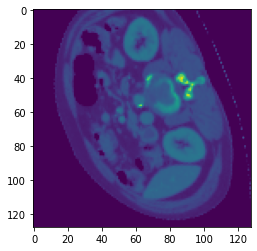

In [19]:
import matplotlib.pyplot as plt

sample_train = train_dataset[9]
plt.imshow(sample_train[0][2][PATCH_SIZE//2])

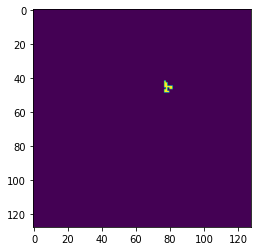

In [20]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [21]:
import multiprocessing
multiprocessing.cpu_count()

48

In [22]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [23]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [24]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [25]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [26]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=3, out_channels=4, num_groups=32, f_maps=32, testing=True, num_levels=LEVELS)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.001, weight_decay=0.0001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [27]:
segmentation_model

DataParallel(
  (module): DropResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DropResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 3, eps=1e-05, affine=True)
            (conv): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (dropout): Dropout(p=0.5, inplace=False)
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
    

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

141494538

In [29]:
from util.util import enumerateWithEstimate
from monai.losses import DiceLoss

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True).unsqueeze(1)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
#     prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    prediction_g = prediction_g_multi_ch
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.CrossEntropyLoss()
    ceLoss_g = ceLoss(prediction_g, label_g.squeeze(1).long())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3,4])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3,4])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3,4])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True).unsqueeze(1)

    prediction_g_multi_ch = segmentation_model(input_g)
#     prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    prediction_g = prediction_g_multi_ch
    diceLoss_g = diceLoss(prediction_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3,4])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3,4])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3,4])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean()

diceLoss = DiceLoss(to_onehot_y=True, include_background=False)

In [30]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [31]:
# !pip install setuptools==59.5.0

In [32]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [33]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [34]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 20
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-08-02 01:36:21,474 INFO     pid:1916413 3DUnet:001:<cell line: 1> Starting traning...


In [35]:
for epoch_ndx in range(1, 51):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-08-02 01:36:21,485 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1 of 1000, 20/12 batches of size 3*4
2022-08-02 01:36:21,490 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1 Training ----/20, starting
2022-08-02 01:37:22,839 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1 Training   16/20, done at 2022-08-02 01:37:29, 0:00:28
2022-08-02 01:37:30,197 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1 Training ----/20, done at 2022-08-02 01:37:30
2022-08-02 01:37:30,201 INFO     pid:1916413 3DUnet:004:logMetrics E1 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 01:37:30,203 INFO     pid:1916413 3DUnet:035:logMetrics E1 trn      0.9985 loss, 0.0021 precision, 0.3882 recall, 0.0042 f1 score
2022-08-02 01:37:30,204 INFO     pid:1916413 3DUnet:045:logMetrics E1 trn_all  0.9985 loss,  38.8% tp,  61.2% fn,   18364.0% fp
2022-08-02 01:37:30,217 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1 Validation  ----/12, starting

2022-08-02 01:44:56,959 INFO     pid:1916413 util.util:236:enumerateWithEstimate E9 Training   16/20, done at 2022-08-02 01:45:04, 0:00:28
2022-08-02 01:45:04,386 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E9 Training ----/20, done at 2022-08-02 01:45:04
2022-08-02 01:45:04,389 INFO     pid:1916413 3DUnet:004:logMetrics E9 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 01:45:04,390 INFO     pid:1916413 3DUnet:035:logMetrics E9 trn      0.9700 loss, 0.0023 precision, 0.2976 recall, 0.0046 f1 score
2022-08-02 01:45:04,391 INFO     pid:1916413 3DUnet:045:logMetrics E9 trn_all  0.9700 loss,  29.8% tp,  70.2% fn,   12787.2% fp
2022-08-02 01:45:04,394 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 10 of 1000, 20/12 batches of size 3*4
2022-08-02 01:45:04,397 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E10 Training ----/20, starting
2022-08-02 01:45:52,305 INFO     pid:1916413 util.util:236:enumerateWithEstimate E10 Training   16/20, done at 

2022-08-02 01:52:38,215 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E17 Training ----/20, done at 2022-08-02 01:52:38
2022-08-02 01:52:38,219 INFO     pid:1916413 3DUnet:004:logMetrics E17 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 01:52:38,221 INFO     pid:1916413 3DUnet:035:logMetrics E17 trn      0.9623 loss, 0.0024 precision, 0.2928 recall, 0.0048 f1 score
2022-08-02 01:52:38,222 INFO     pid:1916413 3DUnet:045:logMetrics E17 trn_all  0.9623 loss,  29.3% tp,  70.7% fn,   12017.6% fp
2022-08-02 01:52:38,227 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 18 of 1000, 20/12 batches of size 3*4
2022-08-02 01:52:38,230 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E18 Training ----/20, starting
2022-08-02 01:53:25,583 INFO     pid:1916413 util.util:236:enumerateWithEstimate E18 Training   16/20, done at 2022-08-02 01:53:32, 0:00:28
2022-08-02 01:53:32,992 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E18 Training ----/20, don

2022-08-02 02:00:14,209 INFO     pid:1916413 3DUnet:004:logMetrics E25 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 02:00:14,212 INFO     pid:1916413 3DUnet:035:logMetrics E25 trn      0.9573 loss, 0.0024 precision, 0.2911 recall, 0.0048 f1 score
2022-08-02 02:00:14,213 INFO     pid:1916413 3DUnet:045:logMetrics E25 trn_all  0.9573 loss,  29.1% tp,  70.9% fn,   12093.9% fp
2022-08-02 02:00:14,218 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 26 of 1000, 20/12 batches of size 3*4
2022-08-02 02:00:14,222 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E26 Training ----/20, starting
2022-08-02 02:01:01,311 INFO     pid:1916413 util.util:236:enumerateWithEstimate E26 Training   16/20, done at 2022-08-02 02:01:08, 0:00:28
2022-08-02 02:01:08,745 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E26 Training ----/20, done at 2022-08-02 02:01:08
2022-08-02 02:01:08,749 INFO     pid:1916413 3DUnet:004:logMetrics E26 Unet bonemeta_fn_0_3D_Unet_DropRes_

2022-08-02 02:07:50,488 INFO     pid:1916413 3DUnet:035:logMetrics E33 trn      0.9554 loss, 0.0023 precision, 0.2935 recall, 0.0046 f1 score
2022-08-02 02:07:50,490 INFO     pid:1916413 3DUnet:045:logMetrics E33 trn_all  0.9554 loss,  29.3% tp,  70.7% fn,   12513.4% fp
2022-08-02 02:07:50,494 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 34 of 1000, 20/12 batches of size 3*4
2022-08-02 02:07:50,497 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E34 Training ----/20, starting
2022-08-02 02:08:38,301 INFO     pid:1916413 util.util:236:enumerateWithEstimate E34 Training   16/20, done at 2022-08-02 02:08:45, 0:00:28
2022-08-02 02:08:45,776 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E34 Training ----/20, done at 2022-08-02 02:08:45
2022-08-02 02:08:45,780 INFO     pid:1916413 3DUnet:004:logMetrics E34 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 02:08:45,782 INFO     pid:1916413 3DUnet:035:logMetrics E34 trn      0.9511 loss, 0.0025 precis

2022-08-02 02:15:29,586 INFO     pid:1916413 3DUnet:045:logMetrics E41 trn_all  0.9512 loss,  28.8% tp,  71.2% fn,   11798.1% fp
2022-08-02 02:15:29,590 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 42 of 1000, 20/12 batches of size 3*4
2022-08-02 02:15:29,593 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E42 Training ----/20, starting
2022-08-02 02:16:18,293 INFO     pid:1916413 util.util:236:enumerateWithEstimate E42 Training   16/20, done at 2022-08-02 02:16:25, 0:00:28
2022-08-02 02:16:25,767 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E42 Training ----/20, done at 2022-08-02 02:16:25
2022-08-02 02:16:25,773 INFO     pid:1916413 3DUnet:004:logMetrics E42 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 02:16:25,775 INFO     pid:1916413 3DUnet:035:logMetrics E42 trn      0.9501 loss, 0.0024 precision, 0.2908 recall, 0.0048 f1 score
2022-08-02 02:16:25,776 INFO     pid:1916413 3DUnet:045:logMetrics E42 trn_all  0.9501 loss,  29.1% tp,  7

2022-08-02 02:23:59,702 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E50 Validation  ----/12, done at 2022-08-02 02:23:59
2022-08-02 02:23:59,704 INFO     pid:1916413 3DUnet:004:logMetrics E50 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 02:23:59,706 INFO     pid:1916413 3DUnet:035:logMetrics E50 val      0.9261 loss, 0.0018 precision, 0.3312 recall, 0.0036 f1 score
2022-08-02 02:23:59,707 INFO     pid:1916413 3DUnet:045:logMetrics E50 val_all  0.9261 loss,  33.1% tp,  66.9% fn,   18328.4% fp
2022-08-02 02:24:03,643 INFO     pid:1916413 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out_model_epoch50
2022-08-02 02:24:06,594 INFO     pid:1916413 3DUnet:032:saveModel SHA1: 9fa24f8acb4f0e2a4662c3df2195c61dba273c3f


In [36]:
for g in optimizer.param_groups:
    g['lr'] = 0.001
    g['weight_decay'] = 0.0002

In [41]:
for epoch_ndx in range(1001, 2001):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-08-02 22:49:02,291 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1001 of 1000, 20/12 batches of size 3*4
2022-08-02 22:49:02,311 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1001 Training ----/20, starting
2022-08-02 22:49:51,991 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1001 Training   16/20, done at 2022-08-02 22:49:59, 0:00:29
2022-08-02 22:49:59,466 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1001 Training ----/20, done at 2022-08-02 22:49:59
2022-08-02 22:49:59,468 INFO     pid:1916413 3DUnet:004:logMetrics E1001 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 22:49:59,470 INFO     pid:1916413 3DUnet:035:logMetrics E1001 trn      0.8507 loss, 0.0029 precision, 0.3668 recall, 0.0058 f1 score
2022-08-02 22:49:59,471 INFO     pid:1916413 3DUnet:045:logMetrics E1001 trn_all  0.8507 loss,  36.7% tp,  63.3% fn,   12409.6% fp
2022-08-02 22:49:59,476 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1002 of 1000, 2

2022-08-02 22:57:22,563 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1010 Training ----/20, starting
2022-08-02 22:58:10,617 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1010 Training   16/20, done at 2022-08-02 22:58:17, 0:00:28
2022-08-02 22:58:18,076 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1010 Training ----/20, done at 2022-08-02 22:58:18
2022-08-02 22:58:18,080 INFO     pid:1916413 3DUnet:004:logMetrics E1010 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 22:58:18,082 INFO     pid:1916413 3DUnet:035:logMetrics E1010 trn      0.8525 loss, 0.0030 precision, 0.3577 recall, 0.0060 f1 score
2022-08-02 22:58:18,083 INFO     pid:1916413 3DUnet:045:logMetrics E1010 trn_all  0.8525 loss,  35.8% tp,  64.2% fn,   11708.8% fp
2022-08-02 22:58:18,087 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1011 of 1000, 20/12 batches of size 3*4
2022-08-02 22:58:18,091 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1011 Train

2022-08-02 23:06:32,314 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1019 Training   16/20, done at 2022-08-02 23:06:39, 0:00:28
2022-08-02 23:06:39,784 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1019 Training ----/20, done at 2022-08-02 23:06:39
2022-08-02 23:06:39,787 INFO     pid:1916413 3DUnet:004:logMetrics E1019 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 23:06:39,788 INFO     pid:1916413 3DUnet:035:logMetrics E1019 trn      0.8465 loss, 0.0031 precision, 0.3674 recall, 0.0061 f1 score
2022-08-02 23:06:39,789 INFO     pid:1916413 3DUnet:045:logMetrics E1019 trn_all  0.8465 loss,  36.7% tp,  63.3% fn,   11987.5% fp
2022-08-02 23:06:39,792 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1020 of 1000, 20/12 batches of size 3*4
2022-08-02 23:06:39,794 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1020 Training ----/20, starting
2022-08-02 23:07:28,150 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1020 Train

2022-08-02 23:15:03,166 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1028 Training ----/20, done at 2022-08-02 23:15:03
2022-08-02 23:15:03,172 INFO     pid:1916413 3DUnet:004:logMetrics E1028 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 23:15:03,174 INFO     pid:1916413 3DUnet:035:logMetrics E1028 trn      0.8529 loss, 0.0031 precision, 0.3640 recall, 0.0061 f1 score
2022-08-02 23:15:03,175 INFO     pid:1916413 3DUnet:045:logMetrics E1028 trn_all  0.8529 loss,  36.4% tp,  63.6% fn,   11820.6% fp
2022-08-02 23:15:03,180 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1029 of 1000, 20/12 batches of size 3*4
2022-08-02 23:15:03,184 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1029 Training ----/20, starting
2022-08-02 23:15:51,636 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1029 Training   16/20, done at 2022-08-02 23:15:58, 0:00:28
2022-08-02 23:15:59,094 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1029 Train

2022-08-02 23:23:25,815 INFO     pid:1916413 3DUnet:004:logMetrics E1037 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 23:23:25,817 INFO     pid:1916413 3DUnet:035:logMetrics E1037 trn      0.8439 loss, 0.0030 precision, 0.3662 recall, 0.0060 f1 score
2022-08-02 23:23:25,819 INFO     pid:1916413 3DUnet:045:logMetrics E1037 trn_all  0.8439 loss,  36.6% tp,  63.4% fn,   12032.8% fp
2022-08-02 23:23:25,823 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1038 of 1000, 20/12 batches of size 3*4
2022-08-02 23:23:25,826 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1038 Training ----/20, starting
2022-08-02 23:24:14,400 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1038 Training   16/20, done at 2022-08-02 23:24:21, 0:00:28
2022-08-02 23:24:21,853 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1038 Training ----/20, done at 2022-08-02 23:24:21
2022-08-02 23:24:21,857 INFO     pid:1916413 3DUnet:004:logMetrics E1038 Unet bonemeta_fn_0_

2022-08-02 23:31:49,357 INFO     pid:1916413 3DUnet:035:logMetrics E1046 trn      0.8518 loss, 0.0030 precision, 0.3670 recall, 0.0059 f1 score
2022-08-02 23:31:49,358 INFO     pid:1916413 3DUnet:045:logMetrics E1046 trn_all  0.8518 loss,  36.7% tp,  63.3% fn,   12313.0% fp
2022-08-02 23:31:49,362 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1047 of 1000, 20/12 batches of size 3*4
2022-08-02 23:31:49,366 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1047 Training ----/20, starting
2022-08-02 23:32:38,103 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1047 Training   16/20, done at 2022-08-02 23:32:45, 0:00:28
2022-08-02 23:32:45,544 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1047 Training ----/20, done at 2022-08-02 23:32:45
2022-08-02 23:32:45,548 INFO     pid:1916413 3DUnet:004:logMetrics E1047 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 23:32:45,551 INFO     pid:1916413 3DUnet:035:logMetrics E1047 trn      0.8519 los

2022-08-02 23:39:28,150 INFO     pid:1916413 3DUnet:035:logMetrics E1054 trn      0.8429 loss, 0.0030 precision, 0.3654 recall, 0.0059 f1 score
2022-08-02 23:39:28,151 INFO     pid:1916413 3DUnet:045:logMetrics E1054 trn_all  0.8429 loss,  36.5% tp,  63.5% fn,   12189.6% fp
2022-08-02 23:39:28,156 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1055 of 1000, 20/12 batches of size 3*4
2022-08-02 23:39:28,159 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1055 Training ----/20, starting
2022-08-02 23:40:16,217 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1055 Training   16/20, done at 2022-08-02 23:40:23, 0:00:28
2022-08-02 23:40:23,671 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1055 Training ----/20, done at 2022-08-02 23:40:23
2022-08-02 23:40:23,675 INFO     pid:1916413 3DUnet:004:logMetrics E1055 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 23:40:23,677 INFO     pid:1916413 3DUnet:035:logMetrics E1055 trn      0.8472 los

2022-08-02 23:47:50,652 INFO     pid:1916413 3DUnet:045:logMetrics E1063 trn_all  0.8464 loss,  36.2% tp,  63.8% fn,   11780.3% fp
2022-08-02 23:47:50,657 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1064 of 1000, 20/12 batches of size 3*4
2022-08-02 23:47:50,660 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1064 Training ----/20, starting
2022-08-02 23:48:38,177 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1064 Training   16/20, done at 2022-08-02 23:48:45, 0:00:28
2022-08-02 23:48:45,632 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1064 Training ----/20, done at 2022-08-02 23:48:45
2022-08-02 23:48:45,636 INFO     pid:1916413 3DUnet:004:logMetrics E1064 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 23:48:45,638 INFO     pid:1916413 3DUnet:035:logMetrics E1064 trn      0.8454 loss, 0.0031 precision, 0.3701 recall, 0.0061 f1 score
2022-08-02 23:48:45,639 INFO     pid:1916413 3DUnet:045:logMetrics E1064 trn_all  0.8454 los

2022-08-02 23:56:11,694 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1073 of 1000, 20/12 batches of size 3*4
2022-08-02 23:56:11,697 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1073 Training ----/20, starting
2022-08-02 23:56:59,784 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1073 Training   16/20, done at 2022-08-02 23:57:06, 0:00:28
2022-08-02 23:57:07,262 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1073 Training ----/20, done at 2022-08-02 23:57:07
2022-08-02 23:57:07,266 INFO     pid:1916413 3DUnet:004:logMetrics E1073 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-02 23:57:07,268 INFO     pid:1916413 3DUnet:035:logMetrics E1073 trn      0.8470 loss, 0.0029 precision, 0.3680 recall, 0.0058 f1 score
2022-08-02 23:57:07,269 INFO     pid:1916413 3DUnet:045:logMetrics E1073 trn_all  0.8470 loss,  36.8% tp,  63.2% fn,   12562.8% fp
2022-08-02 23:57:07,274 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1074 of 1000, 2

2022-08-03 00:04:31,621 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1082 Training ----/20, starting
2022-08-03 00:05:20,318 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1082 Training   16/20, done at 2022-08-03 00:05:27, 0:00:28
2022-08-03 00:05:27,784 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1082 Training ----/20, done at 2022-08-03 00:05:27
2022-08-03 00:05:27,788 INFO     pid:1916413 3DUnet:004:logMetrics E1082 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:05:27,790 INFO     pid:1916413 3DUnet:035:logMetrics E1082 trn      0.8436 loss, 0.0030 precision, 0.3689 recall, 0.0059 f1 score
2022-08-03 00:05:27,791 INFO     pid:1916413 3DUnet:045:logMetrics E1082 trn_all  0.8436 loss,  36.9% tp,  63.1% fn,   12411.0% fp
2022-08-03 00:05:27,795 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1083 of 1000, 20/12 batches of size 3*4
2022-08-03 00:05:27,798 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1083 Train

2022-08-03 00:13:41,986 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1091 Training   16/20, done at 2022-08-03 00:13:49, 0:00:28
2022-08-03 00:13:49,450 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1091 Training ----/20, done at 2022-08-03 00:13:49
2022-08-03 00:13:49,454 INFO     pid:1916413 3DUnet:004:logMetrics E1091 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:13:49,456 INFO     pid:1916413 3DUnet:035:logMetrics E1091 trn      0.8461 loss, 0.0031 precision, 0.3720 recall, 0.0061 f1 score
2022-08-03 00:13:49,457 INFO     pid:1916413 3DUnet:045:logMetrics E1091 trn_all  0.8461 loss,  37.2% tp,  62.8% fn,   11989.9% fp
2022-08-03 00:13:49,462 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1092 of 1000, 20/12 batches of size 3*4
2022-08-03 00:13:49,465 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1092 Training ----/20, starting
2022-08-03 00:14:37,779 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1092 Train

2022-08-03 00:22:12,712 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1100 Training ----/20, done at 2022-08-03 00:22:12
2022-08-03 00:22:12,717 INFO     pid:1916413 3DUnet:004:logMetrics E1100 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:22:12,719 INFO     pid:1916413 3DUnet:035:logMetrics E1100 trn      0.8469 loss, 0.0030 precision, 0.3691 recall, 0.0060 f1 score
2022-08-03 00:22:12,720 INFO     pid:1916413 3DUnet:045:logMetrics E1100 trn_all  0.8469 loss,  36.9% tp,  63.1% fn,   12248.9% fp
2022-08-03 00:22:12,727 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1100 Validation  ----/12, starting
2022-08-03 00:22:20,232 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1100 Validation  ----/12, done at 2022-08-03 00:22:20
2022-08-03 00:22:20,234 INFO     pid:1916413 3DUnet:004:logMetrics E1100 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:22:20,236 INFO     pid:1916413 3DUnet:035:logMetrics E1100 val      0.7

2022-08-03 00:29:52,637 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1108 Training ----/20, done at 2022-08-03 00:29:52
2022-08-03 00:29:52,641 INFO     pid:1916413 3DUnet:004:logMetrics E1108 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:29:52,643 INFO     pid:1916413 3DUnet:035:logMetrics E1108 trn      0.8469 loss, 0.0030 precision, 0.3687 recall, 0.0060 f1 score
2022-08-03 00:29:52,644 INFO     pid:1916413 3DUnet:045:logMetrics E1108 trn_all  0.8469 loss,  36.9% tp,  63.1% fn,   12133.5% fp
2022-08-03 00:29:52,648 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1109 of 1000, 20/12 batches of size 3*4
2022-08-03 00:29:52,652 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1109 Training ----/20, starting
2022-08-03 00:30:40,211 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1109 Training   16/20, done at 2022-08-03 00:30:47, 0:00:28
2022-08-03 00:30:47,680 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1109 Train

2022-08-03 00:38:13,000 INFO     pid:1916413 3DUnet:004:logMetrics E1117 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:38:13,002 INFO     pid:1916413 3DUnet:035:logMetrics E1117 trn      0.8422 loss, 0.0031 precision, 0.3683 recall, 0.0061 f1 score
2022-08-03 00:38:13,002 INFO     pid:1916413 3DUnet:045:logMetrics E1117 trn_all  0.8422 loss,  36.8% tp,  63.2% fn,   11958.5% fp
2022-08-03 00:38:13,005 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1118 of 1000, 20/12 batches of size 3*4
2022-08-03 00:38:13,007 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1118 Training ----/20, starting
2022-08-03 00:39:01,232 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1118 Training   16/20, done at 2022-08-03 00:39:08, 0:00:28
2022-08-03 00:39:08,659 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1118 Training ----/20, done at 2022-08-03 00:39:08
2022-08-03 00:39:08,663 INFO     pid:1916413 3DUnet:004:logMetrics E1118 Unet bonemeta_fn_0_

2022-08-03 00:46:35,326 INFO     pid:1916413 3DUnet:035:logMetrics E1126 trn      0.8443 loss, 0.0031 precision, 0.3700 recall, 0.0061 f1 score
2022-08-03 00:46:35,327 INFO     pid:1916413 3DUnet:045:logMetrics E1126 trn_all  0.8443 loss,  37.0% tp,  63.0% fn,   11938.8% fp
2022-08-03 00:46:35,331 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1127 of 1000, 20/12 batches of size 3*4
2022-08-03 00:46:35,334 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1127 Training ----/20, starting
2022-08-03 00:47:24,061 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1127 Training   16/20, done at 2022-08-03 00:47:31, 0:00:28
2022-08-03 00:47:31,538 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1127 Training ----/20, done at 2022-08-03 00:47:31
2022-08-03 00:47:31,542 INFO     pid:1916413 3DUnet:004:logMetrics E1127 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:47:31,544 INFO     pid:1916413 3DUnet:035:logMetrics E1127 trn      0.8436 los

2022-08-03 00:54:57,417 INFO     pid:1916413 3DUnet:045:logMetrics E1135 trn_all  0.8453 loss,  36.5% tp,  63.5% fn,   12254.1% fp
2022-08-03 00:54:57,421 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1136 of 1000, 20/12 batches of size 3*4
2022-08-03 00:54:57,425 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1136 Training ----/20, starting
2022-08-03 00:55:45,847 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1136 Training   16/20, done at 2022-08-03 00:55:52, 0:00:28
2022-08-03 00:55:53,316 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1136 Training ----/20, done at 2022-08-03 00:55:53
2022-08-03 00:55:53,320 INFO     pid:1916413 3DUnet:004:logMetrics E1136 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 00:55:53,322 INFO     pid:1916413 3DUnet:035:logMetrics E1136 trn      0.8457 loss, 0.0031 precision, 0.3691 recall, 0.0061 f1 score
2022-08-03 00:55:53,323 INFO     pid:1916413 3DUnet:045:logMetrics E1136 trn_all  0.8457 los

2022-08-03 01:03:17,228 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1145 of 1000, 20/12 batches of size 3*4
2022-08-03 01:03:17,231 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1145 Training ----/20, starting
2022-08-03 01:04:04,930 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1145 Training   16/20, done at 2022-08-03 01:04:12, 0:00:28
2022-08-03 01:04:12,346 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1145 Training ----/20, done at 2022-08-03 01:04:12
2022-08-03 01:04:12,352 INFO     pid:1916413 3DUnet:004:logMetrics E1145 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 01:04:12,354 INFO     pid:1916413 3DUnet:035:logMetrics E1145 trn      0.8429 loss, 0.0030 precision, 0.3684 recall, 0.0059 f1 score
2022-08-03 01:04:12,355 INFO     pid:1916413 3DUnet:045:logMetrics E1145 trn_all  0.8429 loss,  36.8% tp,  63.2% fn,   12306.1% fp
2022-08-03 01:04:12,359 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1146 of 1000, 2

2022-08-03 01:10:58,538 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1153 of 1000, 20/12 batches of size 3*4
2022-08-03 01:10:58,541 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1153 Training ----/20, starting
2022-08-03 01:11:47,474 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1153 Training   16/20, done at 2022-08-03 01:11:54, 0:00:28
2022-08-03 01:11:54,932 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1153 Training ----/20, done at 2022-08-03 01:11:54
2022-08-03 01:11:54,936 INFO     pid:1916413 3DUnet:004:logMetrics E1153 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 01:11:54,938 INFO     pid:1916413 3DUnet:035:logMetrics E1153 trn      0.8501 loss, 0.0031 precision, 0.3683 recall, 0.0062 f1 score
2022-08-03 01:11:54,939 INFO     pid:1916413 3DUnet:045:logMetrics E1153 trn_all  0.8501 loss,  36.8% tp,  63.2% fn,   11767.0% fp
2022-08-03 01:11:54,943 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1154 of 1000, 2

2022-08-03 01:19:18,360 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1162 Training ----/20, starting
2022-08-03 01:20:07,199 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1162 Training   16/20, done at 2022-08-03 01:20:14, 0:00:28
2022-08-03 01:20:14,659 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1162 Training ----/20, done at 2022-08-03 01:20:14
2022-08-03 01:20:14,663 INFO     pid:1916413 3DUnet:004:logMetrics E1162 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 01:20:14,665 INFO     pid:1916413 3DUnet:035:logMetrics E1162 trn      0.8441 loss, 0.0030 precision, 0.3681 recall, 0.0060 f1 score
2022-08-03 01:20:14,666 INFO     pid:1916413 3DUnet:045:logMetrics E1162 trn_all  0.8441 loss,  36.8% tp,  63.2% fn,   12101.1% fp
2022-08-03 01:20:14,670 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1163 of 1000, 20/12 batches of size 3*4
2022-08-03 01:20:14,673 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1163 Train

2022-08-03 01:28:30,633 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1171 Training   16/20, done at 2022-08-03 01:28:37, 0:00:28
2022-08-03 01:28:38,084 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1171 Training ----/20, done at 2022-08-03 01:28:38
2022-08-03 01:28:38,088 INFO     pid:1916413 3DUnet:004:logMetrics E1171 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 01:28:38,090 INFO     pid:1916413 3DUnet:035:logMetrics E1171 trn      0.8390 loss, 0.0030 precision, 0.3734 recall, 0.0060 f1 score
2022-08-03 01:28:38,091 INFO     pid:1916413 3DUnet:045:logMetrics E1171 trn_all  0.8390 loss,  37.3% tp,  62.7% fn,   12387.8% fp
2022-08-03 01:28:38,095 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1172 of 1000, 20/12 batches of size 3*4
2022-08-03 01:28:38,099 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1172 Training ----/20, starting
2022-08-03 01:29:26,256 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1172 Train

2022-08-03 01:36:57,827 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1180 Training ----/20, done at 2022-08-03 01:36:57
2022-08-03 01:36:57,831 INFO     pid:1916413 3DUnet:004:logMetrics E1180 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 01:36:57,832 INFO     pid:1916413 3DUnet:035:logMetrics E1180 trn      0.8341 loss, 0.0030 precision, 0.3737 recall, 0.0059 f1 score
2022-08-03 01:36:57,834 INFO     pid:1916413 3DUnet:045:logMetrics E1180 trn_all  0.8341 loss,  37.4% tp,  62.6% fn,   12488.5% fp
2022-08-03 01:36:57,838 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1181 of 1000, 20/12 batches of size 3*4
2022-08-03 01:36:57,841 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1181 Training ----/20, starting
2022-08-03 01:37:45,630 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1181 Training   16/20, done at 2022-08-03 01:37:52, 0:00:28
2022-08-03 01:37:53,447 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1181 Train

2022-08-03 01:45:23,847 INFO     pid:1916413 3DUnet:004:logMetrics E1189 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 01:45:23,849 INFO     pid:1916413 3DUnet:035:logMetrics E1189 trn      0.8378 loss, 0.0031 precision, 0.3744 recall, 0.0061 f1 score
2022-08-03 01:45:23,850 INFO     pid:1916413 3DUnet:045:logMetrics E1189 trn_all  0.8378 loss,  37.4% tp,  62.6% fn,   12135.0% fp
2022-08-03 01:45:23,854 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1190 of 1000, 20/12 batches of size 3*4
2022-08-03 01:45:23,858 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1190 Training ----/20, starting
2022-08-03 01:46:11,323 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1190 Training   16/20, done at 2022-08-03 01:46:18, 0:00:28
2022-08-03 01:46:18,768 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1190 Training ----/20, done at 2022-08-03 01:46:18
2022-08-03 01:46:18,771 INFO     pid:1916413 3DUnet:004:logMetrics E1190 Unet bonemeta_fn_0_

2022-08-03 01:53:47,117 INFO     pid:1916413 3DUnet:035:logMetrics E1198 trn      0.8442 loss, 0.0031 precision, 0.3708 recall, 0.0062 f1 score
2022-08-03 01:53:47,118 INFO     pid:1916413 3DUnet:045:logMetrics E1198 trn_all  0.8442 loss,  37.1% tp,  62.9% fn,   11900.7% fp
2022-08-03 01:53:47,122 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1199 of 1000, 20/12 batches of size 3*4
2022-08-03 01:53:47,125 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1199 Training ----/20, starting
2022-08-03 01:54:35,180 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1199 Training   16/20, done at 2022-08-03 01:54:42, 0:00:28
2022-08-03 01:54:42,613 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1199 Training ----/20, done at 2022-08-03 01:54:42
2022-08-03 01:54:42,616 INFO     pid:1916413 3DUnet:004:logMetrics E1199 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 01:54:42,619 INFO     pid:1916413 3DUnet:035:logMetrics E1199 trn      0.8398 los

2022-08-03 02:01:27,013 INFO     pid:1916413 3DUnet:035:logMetrics E1206 trn      0.8421 loss, 0.0032 precision, 0.3700 recall, 0.0063 f1 score
2022-08-03 02:01:27,014 INFO     pid:1916413 3DUnet:045:logMetrics E1206 trn_all  0.8421 loss,  37.0% tp,  63.0% fn,   11678.9% fp
2022-08-03 02:01:27,018 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1207 of 1000, 20/12 batches of size 3*4
2022-08-03 02:01:27,021 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1207 Training ----/20, starting
2022-08-03 02:02:15,192 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1207 Training   16/20, done at 2022-08-03 02:02:22, 0:00:28
2022-08-03 02:02:22,701 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1207 Training ----/20, done at 2022-08-03 02:02:22
2022-08-03 02:02:22,705 INFO     pid:1916413 3DUnet:004:logMetrics E1207 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 02:02:22,707 INFO     pid:1916413 3DUnet:035:logMetrics E1207 trn      0.8409 los

2022-08-03 02:09:49,428 INFO     pid:1916413 3DUnet:045:logMetrics E1215 trn_all  0.8368 loss,  37.0% tp,  63.0% fn,   12350.0% fp
2022-08-03 02:09:49,432 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1216 of 1000, 20/12 batches of size 3*4
2022-08-03 02:09:49,434 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1216 Training ----/20, starting
2022-08-03 02:10:37,880 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1216 Training   16/20, done at 2022-08-03 02:10:45, 0:00:28
2022-08-03 02:10:45,341 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1216 Training ----/20, done at 2022-08-03 02:10:45
2022-08-03 02:10:45,345 INFO     pid:1916413 3DUnet:004:logMetrics E1216 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 02:10:45,346 INFO     pid:1916413 3DUnet:035:logMetrics E1216 trn      0.8441 loss, 0.0031 precision, 0.3680 recall, 0.0061 f1 score
2022-08-03 02:10:45,348 INFO     pid:1916413 3DUnet:045:logMetrics E1216 trn_all  0.8441 los

2022-08-03 02:18:11,850 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1225 of 1000, 20/12 batches of size 3*4
2022-08-03 02:18:11,854 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1225 Training ----/20, starting
2022-08-03 02:18:59,517 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1225 Training   16/20, done at 2022-08-03 02:19:06, 0:00:28
2022-08-03 02:19:06,951 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1225 Training ----/20, done at 2022-08-03 02:19:06
2022-08-03 02:19:06,954 INFO     pid:1916413 3DUnet:004:logMetrics E1225 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 02:19:06,955 INFO     pid:1916413 3DUnet:035:logMetrics E1225 trn      0.8399 loss, 0.0031 precision, 0.3747 recall, 0.0061 f1 score
2022-08-03 02:19:06,956 INFO     pid:1916413 3DUnet:045:logMetrics E1225 trn_all  0.8399 loss,  37.5% tp,  62.5% fn,   12231.6% fp
2022-08-03 02:19:06,959 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1226 of 1000, 2

2022-08-03 02:26:32,863 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1234 Training ----/20, starting
2022-08-03 02:27:20,910 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1234 Training   16/20, done at 2022-08-03 02:27:28, 0:00:28
2022-08-03 02:27:28,379 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1234 Training ----/20, done at 2022-08-03 02:27:28
2022-08-03 02:27:28,384 INFO     pid:1916413 3DUnet:004:logMetrics E1234 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 02:27:28,386 INFO     pid:1916413 3DUnet:035:logMetrics E1234 trn      0.8429 loss, 0.0030 precision, 0.3738 recall, 0.0060 f1 score
2022-08-03 02:27:28,387 INFO     pid:1916413 3DUnet:045:logMetrics E1234 trn_all  0.8429 loss,  37.4% tp,  62.6% fn,   12256.1% fp
2022-08-03 02:27:28,391 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1235 of 1000, 20/12 batches of size 3*4
2022-08-03 02:27:28,395 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1235 Train

2022-08-03 02:35:43,837 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1243 Training   16/20, done at 2022-08-03 02:35:50, 0:00:28
2022-08-03 02:35:51,373 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1243 Training ----/20, done at 2022-08-03 02:35:51
2022-08-03 02:35:51,377 INFO     pid:1916413 3DUnet:004:logMetrics E1243 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 02:35:51,379 INFO     pid:1916413 3DUnet:035:logMetrics E1243 trn      0.8408 loss, 0.0030 precision, 0.3735 recall, 0.0060 f1 score
2022-08-03 02:35:51,380 INFO     pid:1916413 3DUnet:045:logMetrics E1243 trn_all  0.8408 loss,  37.4% tp,  62.6% fn,   12354.1% fp
2022-08-03 02:35:51,384 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1244 of 1000, 20/12 batches of size 3*4
2022-08-03 02:35:51,388 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1244 Training ----/20, starting
2022-08-03 02:36:39,517 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1244 Train

2022-08-03 02:43:24,625 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1251 Training   16/20, done at 2022-08-03 02:43:31, 0:00:28
2022-08-03 02:43:32,074 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1251 Training ----/20, done at 2022-08-03 02:43:32
2022-08-03 02:43:32,079 INFO     pid:1916413 3DUnet:004:logMetrics E1251 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 02:43:32,081 INFO     pid:1916413 3DUnet:035:logMetrics E1251 trn      0.8413 loss, 0.0031 precision, 0.3756 recall, 0.0062 f1 score
2022-08-03 02:43:32,082 INFO     pid:1916413 3DUnet:045:logMetrics E1251 trn_all  0.8413 loss,  37.6% tp,  62.4% fn,   11911.3% fp
2022-08-03 02:43:32,086 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1252 of 1000, 20/12 batches of size 3*4
2022-08-03 02:43:32,089 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1252 Training ----/20, starting
2022-08-03 02:44:19,940 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1252 Train

2022-08-03 02:51:54,001 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1260 Training ----/20, done at 2022-08-03 02:51:54
2022-08-03 02:51:54,004 INFO     pid:1916413 3DUnet:004:logMetrics E1260 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 02:51:54,006 INFO     pid:1916413 3DUnet:035:logMetrics E1260 trn      0.8324 loss, 0.0030 precision, 0.3796 recall, 0.0060 f1 score
2022-08-03 02:51:54,007 INFO     pid:1916413 3DUnet:045:logMetrics E1260 trn_all  0.8324 loss,  38.0% tp,  62.0% fn,   12420.6% fp
2022-08-03 02:51:54,010 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1261 of 1000, 20/12 batches of size 3*4
2022-08-03 02:51:54,013 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1261 Training ----/20, starting
2022-08-03 02:52:41,990 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1261 Training   16/20, done at 2022-08-03 02:52:49, 0:00:28
2022-08-03 02:52:49,436 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1261 Train

2022-08-03 03:00:12,392 INFO     pid:1916413 3DUnet:004:logMetrics E1269 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:00:12,393 INFO     pid:1916413 3DUnet:035:logMetrics E1269 trn      0.8414 loss, 0.0031 precision, 0.3735 recall, 0.0062 f1 score
2022-08-03 03:00:12,394 INFO     pid:1916413 3DUnet:045:logMetrics E1269 trn_all  0.8414 loss,  37.4% tp,  62.6% fn,   11899.7% fp
2022-08-03 03:00:12,397 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1270 of 1000, 20/12 batches of size 3*4
2022-08-03 03:00:12,400 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1270 Training ----/20, starting
2022-08-03 03:01:00,193 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1270 Training   16/20, done at 2022-08-03 03:01:07, 0:00:28
2022-08-03 03:01:07,656 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1270 Training ----/20, done at 2022-08-03 03:01:07
2022-08-03 03:01:07,660 INFO     pid:1916413 3DUnet:004:logMetrics E1270 Unet bonemeta_fn_0_

2022-08-03 03:08:34,463 INFO     pid:1916413 3DUnet:035:logMetrics E1278 trn      0.8418 loss, 0.0030 precision, 0.3734 recall, 0.0060 f1 score
2022-08-03 03:08:34,464 INFO     pid:1916413 3DUnet:045:logMetrics E1278 trn_all  0.8418 loss,  37.3% tp,  62.7% fn,   12211.9% fp
2022-08-03 03:08:34,469 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1279 of 1000, 20/12 batches of size 3*4
2022-08-03 03:08:34,472 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1279 Training ----/20, starting
2022-08-03 03:09:22,580 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1279 Training   16/20, done at 2022-08-03 03:09:29, 0:00:28
2022-08-03 03:09:30,050 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1279 Training ----/20, done at 2022-08-03 03:09:30
2022-08-03 03:09:30,053 INFO     pid:1916413 3DUnet:004:logMetrics E1279 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:09:30,055 INFO     pid:1916413 3DUnet:035:logMetrics E1279 trn      0.8409 los

2022-08-03 03:16:55,863 INFO     pid:1916413 3DUnet:045:logMetrics E1287 trn_all  0.8398 loss,  37.3% tp,  62.7% fn,   12204.6% fp
2022-08-03 03:16:55,866 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1288 of 1000, 20/12 batches of size 3*4
2022-08-03 03:16:55,869 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1288 Training ----/20, starting
2022-08-03 03:17:43,419 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1288 Training   16/20, done at 2022-08-03 03:17:50, 0:00:28
2022-08-03 03:17:50,871 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1288 Training ----/20, done at 2022-08-03 03:17:50
2022-08-03 03:17:50,876 INFO     pid:1916413 3DUnet:004:logMetrics E1288 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:17:50,878 INFO     pid:1916413 3DUnet:035:logMetrics E1288 trn      0.8438 loss, 0.0031 precision, 0.3721 recall, 0.0061 f1 score
2022-08-03 03:17:50,879 INFO     pid:1916413 3DUnet:045:logMetrics E1288 trn_all  0.8438 los

2022-08-03 03:25:18,354 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1297 of 1000, 20/12 batches of size 3*4
2022-08-03 03:25:18,357 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1297 Training ----/20, starting
2022-08-03 03:26:06,192 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1297 Training   16/20, done at 2022-08-03 03:26:13, 0:00:28
2022-08-03 03:26:13,662 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1297 Training ----/20, done at 2022-08-03 03:26:13
2022-08-03 03:26:13,666 INFO     pid:1916413 3DUnet:004:logMetrics E1297 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:26:13,668 INFO     pid:1916413 3DUnet:035:logMetrics E1297 trn      0.8381 loss, 0.0031 precision, 0.3743 recall, 0.0062 f1 score
2022-08-03 03:26:13,669 INFO     pid:1916413 3DUnet:045:logMetrics E1297 trn_all  0.8381 loss,  37.4% tp,  62.6% fn,   11923.7% fp
2022-08-03 03:26:13,673 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1298 of 1000, 2

2022-08-03 03:32:55,415 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1305 of 1000, 20/12 batches of size 3*4
2022-08-03 03:32:55,419 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1305 Training ----/20, starting
2022-08-03 03:33:44,059 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1305 Training   16/20, done at 2022-08-03 03:33:51, 0:00:28
2022-08-03 03:33:51,482 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1305 Training ----/20, done at 2022-08-03 03:33:51
2022-08-03 03:33:51,485 INFO     pid:1916413 3DUnet:004:logMetrics E1305 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:33:51,487 INFO     pid:1916413 3DUnet:035:logMetrics E1305 trn      0.8351 loss, 0.0031 precision, 0.3760 recall, 0.0061 f1 score
2022-08-03 03:33:51,488 INFO     pid:1916413 3DUnet:045:logMetrics E1305 trn_all  0.8351 loss,  37.6% tp,  62.4% fn,   12187.5% fp
2022-08-03 03:33:51,492 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1306 of 1000, 2

2022-08-03 03:41:16,163 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1314 Training ----/20, starting
2022-08-03 03:42:04,072 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1314 Training   16/20, done at 2022-08-03 03:42:11, 0:00:28
2022-08-03 03:42:11,540 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1314 Training ----/20, done at 2022-08-03 03:42:11
2022-08-03 03:42:11,544 INFO     pid:1916413 3DUnet:004:logMetrics E1314 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:42:11,547 INFO     pid:1916413 3DUnet:035:logMetrics E1314 trn      0.8361 loss, 0.0031 precision, 0.3722 recall, 0.0061 f1 score
2022-08-03 03:42:11,548 INFO     pid:1916413 3DUnet:045:logMetrics E1314 trn_all  0.8361 loss,  37.2% tp,  62.8% fn,   11986.4% fp
2022-08-03 03:42:11,552 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1315 of 1000, 20/12 batches of size 3*4
2022-08-03 03:42:11,556 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1315 Train

2022-08-03 03:50:25,515 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1323 Training   16/20, done at 2022-08-03 03:50:32, 0:00:28
2022-08-03 03:50:32,978 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1323 Training ----/20, done at 2022-08-03 03:50:32
2022-08-03 03:50:32,982 INFO     pid:1916413 3DUnet:004:logMetrics E1323 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:50:32,984 INFO     pid:1916413 3DUnet:035:logMetrics E1323 trn      0.8359 loss, 0.0031 precision, 0.3752 recall, 0.0061 f1 score
2022-08-03 03:50:32,985 INFO     pid:1916413 3DUnet:045:logMetrics E1323 trn_all  0.8359 loss,  37.5% tp,  62.5% fn,   12167.8% fp
2022-08-03 03:50:32,989 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1324 of 1000, 20/12 batches of size 3*4
2022-08-03 03:50:32,992 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1324 Training ----/20, starting
2022-08-03 03:51:21,719 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1324 Train

2022-08-03 03:58:54,196 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1332 Training ----/20, done at 2022-08-03 03:58:54
2022-08-03 03:58:54,201 INFO     pid:1916413 3DUnet:004:logMetrics E1332 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 03:58:54,204 INFO     pid:1916413 3DUnet:035:logMetrics E1332 trn      0.8381 loss, 0.0030 precision, 0.3706 recall, 0.0060 f1 score
2022-08-03 03:58:54,205 INFO     pid:1916413 3DUnet:045:logMetrics E1332 trn_all  0.8381 loss,  37.1% tp,  62.9% fn,   12297.5% fp
2022-08-03 03:58:54,209 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1333 of 1000, 20/12 batches of size 3*4
2022-08-03 03:58:54,212 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1333 Training ----/20, starting
2022-08-03 03:59:42,207 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1333 Training   16/20, done at 2022-08-03 03:59:49, 0:00:28
2022-08-03 03:59:49,623 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1333 Train

2022-08-03 04:07:15,981 INFO     pid:1916413 3DUnet:004:logMetrics E1341 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 04:07:15,983 INFO     pid:1916413 3DUnet:035:logMetrics E1341 trn      0.8367 loss, 0.0031 precision, 0.3724 recall, 0.0062 f1 score
2022-08-03 04:07:15,984 INFO     pid:1916413 3DUnet:045:logMetrics E1341 trn_all  0.8367 loss,  37.2% tp,  62.8% fn,   11878.2% fp
2022-08-03 04:07:15,988 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1342 of 1000, 20/12 batches of size 3*4
2022-08-03 04:07:15,992 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1342 Training ----/20, starting
2022-08-03 04:08:03,892 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1342 Training   16/20, done at 2022-08-03 04:08:11, 0:00:28
2022-08-03 04:08:11,369 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1342 Training ----/20, done at 2022-08-03 04:08:11
2022-08-03 04:08:11,373 INFO     pid:1916413 3DUnet:004:logMetrics E1342 Unet bonemeta_fn_0_

2022-08-03 04:15:36,994 INFO     pid:1916413 3DUnet:035:logMetrics E1350 trn      0.8311 loss, 0.0030 precision, 0.3733 recall, 0.0059 f1 score
2022-08-03 04:15:36,995 INFO     pid:1916413 3DUnet:045:logMetrics E1350 trn_all  0.8311 loss,  37.3% tp,  62.7% fn,   12421.7% fp
2022-08-03 04:15:37,001 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1350 Validation  ----/12, starting
2022-08-03 04:15:44,495 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1350 Validation  ----/12, done at 2022-08-03 04:15:44
2022-08-03 04:15:44,498 INFO     pid:1916413 3DUnet:004:logMetrics E1350 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 04:15:44,500 INFO     pid:1916413 3DUnet:035:logMetrics E1350 val      0.5024 loss, 0.0021 precision, 0.3798 recall, 0.0041 f1 score
2022-08-03 04:15:44,502 INFO     pid:1916413 3DUnet:045:logMetrics E1350 val_all  0.5024 loss,  38.0% tp,  62.0% fn,   18310.5% fp
2022-08-03 04:15:48,372 INFO     pid:1916413 3DUnet:026:saveModel Mode

2022-08-03 04:23:17,705 INFO     pid:1916413 3DUnet:035:logMetrics E1358 trn      0.8352 loss, 0.0031 precision, 0.3749 recall, 0.0061 f1 score
2022-08-03 04:23:17,707 INFO     pid:1916413 3DUnet:045:logMetrics E1358 trn_all  0.8352 loss,  37.5% tp,  62.5% fn,   12101.4% fp
2022-08-03 04:23:17,711 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1359 of 1000, 20/12 batches of size 3*4
2022-08-03 04:23:17,714 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1359 Training ----/20, starting
2022-08-03 04:24:05,428 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1359 Training   16/20, done at 2022-08-03 04:24:12, 0:00:28
2022-08-03 04:24:12,893 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1359 Training ----/20, done at 2022-08-03 04:24:12
2022-08-03 04:24:12,897 INFO     pid:1916413 3DUnet:004:logMetrics E1359 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 04:24:12,900 INFO     pid:1916413 3DUnet:035:logMetrics E1359 trn      0.8325 los

2022-08-03 04:31:38,501 INFO     pid:1916413 3DUnet:045:logMetrics E1367 trn_all  0.8356 loss,  37.5% tp,  62.5% fn,   12221.7% fp
2022-08-03 04:31:38,505 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1368 of 1000, 20/12 batches of size 3*4
2022-08-03 04:31:38,508 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1368 Training ----/20, starting
2022-08-03 04:32:26,928 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1368 Training   16/20, done at 2022-08-03 04:32:34, 0:00:28
2022-08-03 04:32:34,371 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1368 Training ----/20, done at 2022-08-03 04:32:34
2022-08-03 04:32:34,375 INFO     pid:1916413 3DUnet:004:logMetrics E1368 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 04:32:34,377 INFO     pid:1916413 3DUnet:035:logMetrics E1368 trn      0.8324 loss, 0.0032 precision, 0.3812 recall, 0.0064 f1 score
2022-08-03 04:32:34,379 INFO     pid:1916413 3DUnet:045:logMetrics E1368 trn_all  0.8324 los

2022-08-03 04:40:01,175 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1377 of 1000, 20/12 batches of size 3*4
2022-08-03 04:40:01,179 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1377 Training ----/20, starting
2022-08-03 04:40:49,463 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1377 Training   16/20, done at 2022-08-03 04:40:56, 0:00:28
2022-08-03 04:40:56,936 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1377 Training ----/20, done at 2022-08-03 04:40:56
2022-08-03 04:40:56,940 INFO     pid:1916413 3DUnet:004:logMetrics E1377 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 04:40:56,941 INFO     pid:1916413 3DUnet:035:logMetrics E1377 trn      0.8412 loss, 0.0030 precision, 0.3668 recall, 0.0060 f1 score
2022-08-03 04:40:56,943 INFO     pid:1916413 3DUnet:045:logMetrics E1377 trn_all  0.8412 loss,  36.7% tp,  63.3% fn,   12021.6% fp
2022-08-03 04:40:56,947 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1378 of 1000, 2

2022-08-03 04:48:25,508 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1386 Training ----/20, starting
2022-08-03 04:49:14,479 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1386 Training   16/20, done at 2022-08-03 04:49:21, 0:00:28
2022-08-03 04:49:21,953 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1386 Training ----/20, done at 2022-08-03 04:49:21
2022-08-03 04:49:21,957 INFO     pid:1916413 3DUnet:004:logMetrics E1386 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 04:49:21,960 INFO     pid:1916413 3DUnet:035:logMetrics E1386 trn      0.8311 loss, 0.0031 precision, 0.3743 recall, 0.0062 f1 score
2022-08-03 04:49:21,961 INFO     pid:1916413 3DUnet:045:logMetrics E1386 trn_all  0.8311 loss,  37.4% tp,  62.6% fn,   11898.4% fp
2022-08-03 04:49:21,965 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1387 of 1000, 20/12 batches of size 3*4
2022-08-03 04:49:21,969 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1387 Train

2022-08-03 04:57:32,526 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1395 Training   16/20, done at 2022-08-03 04:57:39, 0:00:28
2022-08-03 04:57:40,106 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1395 Training ----/20, done at 2022-08-03 04:57:40
2022-08-03 04:57:40,110 INFO     pid:1916413 3DUnet:004:logMetrics E1395 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 04:57:40,112 INFO     pid:1916413 3DUnet:035:logMetrics E1395 trn      0.8319 loss, 0.0031 precision, 0.3755 recall, 0.0062 f1 score
2022-08-03 04:57:40,113 INFO     pid:1916413 3DUnet:045:logMetrics E1395 trn_all  0.8319 loss,  37.6% tp,  62.4% fn,   12032.5% fp
2022-08-03 04:57:40,117 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1396 of 1000, 20/12 batches of size 3*4
2022-08-03 04:57:40,120 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1396 Training ----/20, starting
2022-08-03 04:58:28,886 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1396 Train

2022-08-03 05:05:12,452 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1403 Training   16/20, done at 2022-08-03 05:05:19, 0:00:28
2022-08-03 05:05:19,891 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1403 Training ----/20, done at 2022-08-03 05:05:19
2022-08-03 05:05:19,895 INFO     pid:1916413 3DUnet:004:logMetrics E1403 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 05:05:19,898 INFO     pid:1916413 3DUnet:035:logMetrics E1403 trn      0.8460 loss, 0.0032 precision, 0.3659 recall, 0.0063 f1 score
2022-08-03 05:05:19,899 INFO     pid:1916413 3DUnet:045:logMetrics E1403 trn_all  0.8460 loss,  36.6% tp,  63.4% fn,   11467.2% fp
2022-08-03 05:05:19,902 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1404 of 1000, 20/12 batches of size 3*4
2022-08-03 05:05:19,906 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1404 Training ----/20, starting
2022-08-03 05:06:07,992 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1404 Train

2022-08-03 05:13:41,687 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1412 Training ----/20, done at 2022-08-03 05:13:41
2022-08-03 05:13:41,692 INFO     pid:1916413 3DUnet:004:logMetrics E1412 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 05:13:41,694 INFO     pid:1916413 3DUnet:035:logMetrics E1412 trn      0.8359 loss, 0.0031 precision, 0.3749 recall, 0.0061 f1 score
2022-08-03 05:13:41,695 INFO     pid:1916413 3DUnet:045:logMetrics E1412 trn_all  0.8359 loss,  37.5% tp,  62.5% fn,   12105.0% fp
2022-08-03 05:13:41,700 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1413 of 1000, 20/12 batches of size 3*4
2022-08-03 05:13:41,702 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1413 Training ----/20, starting
2022-08-03 05:14:29,642 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1413 Training   16/20, done at 2022-08-03 05:14:36, 0:00:28
2022-08-03 05:14:37,104 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1413 Train

2022-08-03 05:22:02,545 INFO     pid:1916413 3DUnet:004:logMetrics E1421 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 05:22:02,547 INFO     pid:1916413 3DUnet:035:logMetrics E1421 trn      0.8409 loss, 0.0030 precision, 0.3710 recall, 0.0059 f1 score
2022-08-03 05:22:02,549 INFO     pid:1916413 3DUnet:045:logMetrics E1421 trn_all  0.8409 loss,  37.1% tp,  62.9% fn,   12405.2% fp
2022-08-03 05:22:02,552 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1422 of 1000, 20/12 batches of size 3*4
2022-08-03 05:22:02,556 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1422 Training ----/20, starting
2022-08-03 05:22:50,431 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1422 Training   16/20, done at 2022-08-03 05:22:57, 0:00:28
2022-08-03 05:22:57,878 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1422 Training ----/20, done at 2022-08-03 05:22:57
2022-08-03 05:22:57,882 INFO     pid:1916413 3DUnet:004:logMetrics E1422 Unet bonemeta_fn_0_

2022-08-03 05:30:23,557 INFO     pid:1916413 3DUnet:035:logMetrics E1430 trn      0.5605 loss, 0.0022 precision, 0.2733 recall, 0.0044 f1 score
2022-08-03 05:30:23,559 INFO     pid:1916413 3DUnet:045:logMetrics E1430 trn_all  0.5605 loss,  27.3% tp,  72.7% fn,   12355.0% fp
2022-08-03 05:30:23,563 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1431 of 1000, 20/12 batches of size 3*4
2022-08-03 05:30:23,566 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1431 Training ----/20, starting
2022-08-03 05:31:11,742 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1431 Training   16/20, done at 2022-08-03 05:31:18, 0:00:28
2022-08-03 05:31:19,230 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1431 Training ----/20, done at 2022-08-03 05:31:19
2022-08-03 05:31:19,234 INFO     pid:1916413 3DUnet:004:logMetrics E1431 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 05:31:19,236 INFO     pid:1916413 3DUnet:035:logMetrics E1431 trn      0.4468 los

2022-08-03 05:38:45,357 INFO     pid:1916413 3DUnet:045:logMetrics E1439 trn_all  0.3491 loss,  29.8% tp,  70.2% fn,   12364.4% fp
2022-08-03 05:38:45,360 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1440 of 1000, 20/12 batches of size 3*4
2022-08-03 05:38:45,363 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1440 Training ----/20, starting
2022-08-03 05:39:33,848 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1440 Training   16/20, done at 2022-08-03 05:39:40, 0:00:28
2022-08-03 05:39:41,303 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1440 Training ----/20, done at 2022-08-03 05:39:41
2022-08-03 05:39:41,307 INFO     pid:1916413 3DUnet:004:logMetrics E1440 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 05:39:41,309 INFO     pid:1916413 3DUnet:035:logMetrics E1440 trn      0.3317 loss, 0.0026 precision, 0.3038 recall, 0.0051 f1 score
2022-08-03 05:39:41,310 INFO     pid:1916413 3DUnet:045:logMetrics E1440 trn_all  0.3317 los

2022-08-03 05:47:06,571 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1449 of 1000, 20/12 batches of size 3*4
2022-08-03 05:47:06,574 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1449 Training ----/20, starting
2022-08-03 05:47:55,407 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1449 Training   16/20, done at 2022-08-03 05:48:02, 0:00:28
2022-08-03 05:48:02,868 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1449 Training ----/20, done at 2022-08-03 05:48:02
2022-08-03 05:48:02,871 INFO     pid:1916413 3DUnet:004:logMetrics E1449 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 05:48:02,874 INFO     pid:1916413 3DUnet:035:logMetrics E1449 trn      0.3199 loss, 0.0027 precision, 0.3297 recall, 0.0053 f1 score
2022-08-03 05:48:02,875 INFO     pid:1916413 3DUnet:045:logMetrics E1449 trn_all  0.3199 loss,  33.0% tp,  67.0% fn,   12335.1% fp
2022-08-03 05:48:02,879 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1450 of 1000, 2

2022-08-03 05:54:47,977 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1457 of 1000, 20/12 batches of size 3*4
2022-08-03 05:54:47,980 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1457 Training ----/20, starting
2022-08-03 05:55:36,656 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1457 Training   16/20, done at 2022-08-03 05:55:43, 0:00:28
2022-08-03 05:55:44,132 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1457 Training ----/20, done at 2022-08-03 05:55:44
2022-08-03 05:55:44,136 INFO     pid:1916413 3DUnet:004:logMetrics E1457 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 05:55:44,137 INFO     pid:1916413 3DUnet:035:logMetrics E1457 trn      0.2828 loss, 0.0027 precision, 0.3355 recall, 0.0053 f1 score
2022-08-03 05:55:44,139 INFO     pid:1916413 3DUnet:045:logMetrics E1457 trn_all  0.2828 loss,  33.6% tp,  66.4% fn,   12414.2% fp
2022-08-03 05:55:44,143 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1458 of 1000, 2

2022-08-03 06:03:09,158 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1466 Training ----/20, starting
2022-08-03 06:03:58,165 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1466 Training   16/20, done at 2022-08-03 06:04:05, 0:00:28
2022-08-03 06:04:05,643 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1466 Training ----/20, done at 2022-08-03 06:04:05
2022-08-03 06:04:05,647 INFO     pid:1916413 3DUnet:004:logMetrics E1466 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 06:04:05,649 INFO     pid:1916413 3DUnet:035:logMetrics E1466 trn      0.2662 loss, 0.0029 precision, 0.3372 recall, 0.0057 f1 score
2022-08-03 06:04:05,650 INFO     pid:1916413 3DUnet:045:logMetrics E1466 trn_all  0.2662 loss,  33.7% tp,  66.3% fn,   11718.2% fp
2022-08-03 06:04:05,654 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1467 of 1000, 20/12 batches of size 3*4
2022-08-03 06:04:05,658 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1467 Train

2022-08-03 06:12:22,388 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1475 Training   16/20, done at 2022-08-03 06:12:29, 0:00:28
2022-08-03 06:12:29,854 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1475 Training ----/20, done at 2022-08-03 06:12:29
2022-08-03 06:12:29,858 INFO     pid:1916413 3DUnet:004:logMetrics E1475 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 06:12:29,861 INFO     pid:1916413 3DUnet:035:logMetrics E1475 trn      0.2345 loss, 0.0028 precision, 0.3469 recall, 0.0055 f1 score
2022-08-03 06:12:29,862 INFO     pid:1916413 3DUnet:045:logMetrics E1475 trn_all  0.2345 loss,  34.7% tp,  65.3% fn,   12423.3% fp
2022-08-03 06:12:29,866 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1476 of 1000, 20/12 batches of size 3*4
2022-08-03 06:12:29,869 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1476 Training ----/20, starting
2022-08-03 06:13:17,726 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1476 Train

2022-08-03 06:20:51,982 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1484 Training ----/20, done at 2022-08-03 06:20:51
2022-08-03 06:20:51,985 INFO     pid:1916413 3DUnet:004:logMetrics E1484 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 06:20:51,987 INFO     pid:1916413 3DUnet:035:logMetrics E1484 trn      0.2123 loss, 0.0029 precision, 0.3420 recall, 0.0057 f1 score
2022-08-03 06:20:51,989 INFO     pid:1916413 3DUnet:045:logMetrics E1484 trn_all  0.2123 loss,  34.2% tp,  65.8% fn,   11913.5% fp
2022-08-03 06:20:51,992 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1485 of 1000, 20/12 batches of size 3*4
2022-08-03 06:20:51,996 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1485 Training ----/20, starting
2022-08-03 06:21:39,664 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1485 Training   16/20, done at 2022-08-03 06:21:46, 0:00:28
2022-08-03 06:21:47,117 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1485 Train

2022-08-03 06:29:14,014 INFO     pid:1916413 3DUnet:004:logMetrics E1493 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 06:29:14,015 INFO     pid:1916413 3DUnet:035:logMetrics E1493 trn      0.2252 loss, 0.0027 precision, 0.3406 recall, 0.0054 f1 score
2022-08-03 06:29:14,016 INFO     pid:1916413 3DUnet:045:logMetrics E1493 trn_all  0.2252 loss,  34.1% tp,  65.9% fn,   12492.7% fp
2022-08-03 06:29:14,019 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1494 of 1000, 20/12 batches of size 3*4
2022-08-03 06:29:14,021 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1494 Training ----/20, starting
2022-08-03 06:30:02,336 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1494 Training   16/20, done at 2022-08-03 06:30:09, 0:00:28
2022-08-03 06:30:09,831 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1494 Training ----/20, done at 2022-08-03 06:30:09
2022-08-03 06:30:09,835 INFO     pid:1916413 3DUnet:004:logMetrics E1494 Unet bonemeta_fn_0_

2022-08-03 06:36:53,281 INFO     pid:1916413 3DUnet:004:logMetrics E1501 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 06:36:53,283 INFO     pid:1916413 3DUnet:035:logMetrics E1501 trn      0.2217 loss, 0.0028 precision, 0.3506 recall, 0.0056 f1 score
2022-08-03 06:36:53,285 INFO     pid:1916413 3DUnet:045:logMetrics E1501 trn_all  0.2217 loss,  35.1% tp,  64.9% fn,   12429.7% fp
2022-08-03 06:36:53,288 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1502 of 1000, 20/12 batches of size 3*4
2022-08-03 06:36:53,292 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1502 Training ----/20, starting
2022-08-03 06:37:41,005 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1502 Training   16/20, done at 2022-08-03 06:37:48, 0:00:28
2022-08-03 06:37:48,460 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1502 Training ----/20, done at 2022-08-03 06:37:48
2022-08-03 06:37:48,464 INFO     pid:1916413 3DUnet:004:logMetrics E1502 Unet bonemeta_fn_0_

2022-08-03 06:45:12,108 INFO     pid:1916413 3DUnet:035:logMetrics E1510 trn      0.2151 loss, 0.0029 precision, 0.3468 recall, 0.0057 f1 score
2022-08-03 06:45:12,109 INFO     pid:1916413 3DUnet:045:logMetrics E1510 trn_all  0.2151 loss,  34.7% tp,  65.3% fn,   12003.6% fp
2022-08-03 06:45:12,113 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1511 of 1000, 20/12 batches of size 3*4
2022-08-03 06:45:12,117 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1511 Training ----/20, starting
2022-08-03 06:46:00,590 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1511 Training   16/20, done at 2022-08-03 06:46:07, 0:00:28
2022-08-03 06:46:08,076 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1511 Training ----/20, done at 2022-08-03 06:46:08
2022-08-03 06:46:08,080 INFO     pid:1916413 3DUnet:004:logMetrics E1511 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 06:46:08,082 INFO     pid:1916413 3DUnet:035:logMetrics E1511 trn      0.2016 los

2022-08-03 06:53:33,990 INFO     pid:1916413 3DUnet:045:logMetrics E1519 trn_all  0.2167 loss,  34.5% tp,  65.5% fn,   11905.3% fp
2022-08-03 06:53:33,994 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1520 of 1000, 20/12 batches of size 3*4
2022-08-03 06:53:33,998 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1520 Training ----/20, starting
2022-08-03 06:54:22,830 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1520 Training   16/20, done at 2022-08-03 06:54:29, 0:00:28
2022-08-03 06:54:30,323 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1520 Training ----/20, done at 2022-08-03 06:54:30
2022-08-03 06:54:30,327 INFO     pid:1916413 3DUnet:004:logMetrics E1520 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 06:54:30,329 INFO     pid:1916413 3DUnet:035:logMetrics E1520 trn      0.2129 loss, 0.0029 precision, 0.3466 recall, 0.0057 f1 score
2022-08-03 06:54:30,330 INFO     pid:1916413 3DUnet:045:logMetrics E1520 trn_all  0.2129 los

2022-08-03 07:01:54,823 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1529 of 1000, 20/12 batches of size 3*4
2022-08-03 07:01:54,826 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1529 Training ----/20, starting
2022-08-03 07:02:42,910 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1529 Training   16/20, done at 2022-08-03 07:02:50, 0:00:28
2022-08-03 07:02:50,360 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1529 Training ----/20, done at 2022-08-03 07:02:50
2022-08-03 07:02:50,365 INFO     pid:1916413 3DUnet:004:logMetrics E1529 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 07:02:50,367 INFO     pid:1916413 3DUnet:035:logMetrics E1529 trn      0.2193 loss, 0.0028 precision, 0.3416 recall, 0.0055 f1 score
2022-08-03 07:02:50,369 INFO     pid:1916413 3DUnet:045:logMetrics E1529 trn_all  0.2193 loss,  34.2% tp,  65.8% fn,   12301.0% fp
2022-08-03 07:02:50,373 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1530 of 1000, 2

2022-08-03 07:10:17,095 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1538 Training ----/20, starting
2022-08-03 07:11:05,364 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1538 Training   16/20, done at 2022-08-03 07:11:12, 0:00:28
2022-08-03 07:11:12,838 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1538 Training ----/20, done at 2022-08-03 07:11:12
2022-08-03 07:11:12,842 INFO     pid:1916413 3DUnet:004:logMetrics E1538 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 07:11:12,844 INFO     pid:1916413 3DUnet:035:logMetrics E1538 trn      0.2001 loss, 0.0030 precision, 0.3550 recall, 0.0059 f1 score
2022-08-03 07:11:12,845 INFO     pid:1916413 3DUnet:045:logMetrics E1538 trn_all  0.2001 loss,  35.5% tp,  64.5% fn,   11960.4% fp
2022-08-03 07:11:12,849 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1539 of 1000, 20/12 batches of size 3*4
2022-08-03 07:11:12,853 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1539 Train

2022-08-03 07:19:24,818 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1547 Training   16/20, done at 2022-08-03 07:19:31, 0:00:28
2022-08-03 07:19:32,316 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1547 Training ----/20, done at 2022-08-03 07:19:32
2022-08-03 07:19:32,320 INFO     pid:1916413 3DUnet:004:logMetrics E1547 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 07:19:32,322 INFO     pid:1916413 3DUnet:035:logMetrics E1547 trn      0.2068 loss, 0.0029 precision, 0.3515 recall, 0.0057 f1 score
2022-08-03 07:19:32,324 INFO     pid:1916413 3DUnet:045:logMetrics E1547 trn_all  0.2068 loss,  35.2% tp,  64.8% fn,   12104.5% fp
2022-08-03 07:19:32,328 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1548 of 1000, 20/12 batches of size 3*4
2022-08-03 07:19:32,331 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1548 Training ----/20, starting
2022-08-03 07:20:20,967 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1548 Train

2022-08-03 07:27:06,314 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1555 Training   16/20, done at 2022-08-03 07:27:13, 0:00:28
2022-08-03 07:27:13,769 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1555 Training ----/20, done at 2022-08-03 07:27:13
2022-08-03 07:27:13,774 INFO     pid:1916413 3DUnet:004:logMetrics E1555 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 07:27:13,776 INFO     pid:1916413 3DUnet:035:logMetrics E1555 trn      0.2000 loss, 0.0029 precision, 0.3589 recall, 0.0058 f1 score
2022-08-03 07:27:13,777 INFO     pid:1916413 3DUnet:045:logMetrics E1555 trn_all  0.2000 loss,  35.9% tp,  64.1% fn,   12182.3% fp
2022-08-03 07:27:13,782 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1556 of 1000, 20/12 batches of size 3*4
2022-08-03 07:27:13,785 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1556 Training ----/20, starting
2022-08-03 07:28:02,127 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1556 Train

2022-08-03 07:35:33,589 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1564 Training ----/20, done at 2022-08-03 07:35:33
2022-08-03 07:35:33,593 INFO     pid:1916413 3DUnet:004:logMetrics E1564 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 07:35:33,595 INFO     pid:1916413 3DUnet:035:logMetrics E1564 trn      0.2046 loss, 0.0029 precision, 0.3527 recall, 0.0058 f1 score
2022-08-03 07:35:33,596 INFO     pid:1916413 3DUnet:045:logMetrics E1564 trn_all  0.2046 loss,  35.3% tp,  64.7% fn,   12017.0% fp
2022-08-03 07:35:33,600 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1565 of 1000, 20/12 batches of size 3*4
2022-08-03 07:35:33,603 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1565 Training ----/20, starting
2022-08-03 07:36:22,441 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1565 Training   16/20, done at 2022-08-03 07:36:29, 0:00:28
2022-08-03 07:36:29,905 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1565 Train

2022-08-03 07:43:56,695 INFO     pid:1916413 3DUnet:004:logMetrics E1573 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 07:43:56,698 INFO     pid:1916413 3DUnet:035:logMetrics E1573 trn      0.1962 loss, 0.0028 precision, 0.3537 recall, 0.0055 f1 score
2022-08-03 07:43:56,699 INFO     pid:1916413 3DUnet:045:logMetrics E1573 trn_all  0.1962 loss,  35.4% tp,  64.6% fn,   12652.7% fp
2022-08-03 07:43:56,703 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1574 of 1000, 20/12 batches of size 3*4
2022-08-03 07:43:56,707 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1574 Training ----/20, starting
2022-08-03 07:44:44,271 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1574 Training   16/20, done at 2022-08-03 07:44:51, 0:00:28
2022-08-03 07:44:51,758 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1574 Training ----/20, done at 2022-08-03 07:44:51
2022-08-03 07:44:51,762 INFO     pid:1916413 3DUnet:004:logMetrics E1574 Unet bonemeta_fn_0_

2022-08-03 07:52:19,651 INFO     pid:1916413 3DUnet:035:logMetrics E1582 trn      0.2037 loss, 0.0029 precision, 0.3576 recall, 0.0057 f1 score
2022-08-03 07:52:19,652 INFO     pid:1916413 3DUnet:045:logMetrics E1582 trn_all  0.2037 loss,  35.8% tp,  64.2% fn,   12473.6% fp
2022-08-03 07:52:19,656 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1583 of 1000, 20/12 batches of size 3*4
2022-08-03 07:52:19,660 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1583 Training ----/20, starting
2022-08-03 07:53:08,698 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1583 Training   16/20, done at 2022-08-03 07:53:15, 0:00:28
2022-08-03 07:53:16,149 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1583 Training ----/20, done at 2022-08-03 07:53:16
2022-08-03 07:53:16,153 INFO     pid:1916413 3DUnet:004:logMetrics E1583 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 07:53:16,155 INFO     pid:1916413 3DUnet:035:logMetrics E1583 trn      0.2105 los

2022-08-03 08:00:42,662 INFO     pid:1916413 3DUnet:045:logMetrics E1591 trn_all  0.1971 loss,  35.7% tp,  64.3% fn,   12101.1% fp
2022-08-03 08:00:42,666 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1592 of 1000, 20/12 batches of size 3*4
2022-08-03 08:00:42,670 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1592 Training ----/20, starting
2022-08-03 08:01:31,515 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1592 Training   16/20, done at 2022-08-03 08:01:38, 0:00:28
2022-08-03 08:01:38,975 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1592 Training ----/20, done at 2022-08-03 08:01:38
2022-08-03 08:01:38,978 INFO     pid:1916413 3DUnet:004:logMetrics E1592 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:01:38,979 INFO     pid:1916413 3DUnet:035:logMetrics E1592 trn      0.1887 loss, 0.0029 precision, 0.3645 recall, 0.0058 f1 score
2022-08-03 08:01:38,980 INFO     pid:1916413 3DUnet:045:logMetrics E1592 trn_all  0.1887 los

2022-08-03 08:09:02,737 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1600 Validation  ----/12, starting
2022-08-03 08:09:10,219 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1600 Validation  ----/12, done at 2022-08-03 08:09:10
2022-08-03 08:09:10,221 INFO     pid:1916413 3DUnet:004:logMetrics E1600 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:09:10,222 INFO     pid:1916413 3DUnet:035:logMetrics E1600 val      0.2152 loss, 0.0019 precision, 0.3568 recall, 0.0039 f1 score
2022-08-03 08:09:10,223 INFO     pid:1916413 3DUnet:045:logMetrics E1600 val_all  0.2152 loss,  35.7% tp,  64.3% fn,   18310.4% fp
2022-08-03 08:09:14,050 INFO     pid:1916413 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out_model_epoch1600
2022-08-03 08:09:16,922 INFO     pid:1916413 3DUnet:032:saveModel SHA1: 87e64ac3cdb23ba2a58aaab25e57171ea019dcb4
2022-08-03 08:09:16,924 INFO     pid:1916413 3D

2022-08-03 08:16:43,794 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1609 of 1000, 20/12 batches of size 3*4
2022-08-03 08:16:43,797 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1609 Training ----/20, starting
2022-08-03 08:17:32,170 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1609 Training   16/20, done at 2022-08-03 08:17:39, 0:00:28
2022-08-03 08:17:39,634 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1609 Training ----/20, done at 2022-08-03 08:17:39
2022-08-03 08:17:39,638 INFO     pid:1916413 3DUnet:004:logMetrics E1609 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:17:39,639 INFO     pid:1916413 3DUnet:035:logMetrics E1609 trn      0.1874 loss, 0.0031 precision, 0.3602 recall, 0.0062 f1 score
2022-08-03 08:17:39,641 INFO     pid:1916413 3DUnet:045:logMetrics E1609 trn_all  0.1874 loss,  36.0% tp,  64.0% fn,   11402.8% fp
2022-08-03 08:17:39,645 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1610 of 1000, 2

2022-08-03 08:25:06,074 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1618 Training ----/20, starting
2022-08-03 08:25:54,440 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1618 Training   16/20, done at 2022-08-03 08:26:01, 0:00:28
2022-08-03 08:26:01,904 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1618 Training ----/20, done at 2022-08-03 08:26:01
2022-08-03 08:26:01,908 INFO     pid:1916413 3DUnet:004:logMetrics E1618 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:26:01,910 INFO     pid:1916413 3DUnet:035:logMetrics E1618 trn      0.1885 loss, 0.0030 precision, 0.3632 recall, 0.0060 f1 score
2022-08-03 08:26:01,912 INFO     pid:1916413 3DUnet:045:logMetrics E1618 trn_all  0.1885 loss,  36.3% tp,  63.7% fn,   11875.3% fp
2022-08-03 08:26:01,916 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1619 of 1000, 20/12 batches of size 3*4
2022-08-03 08:26:01,919 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1619 Train

2022-08-03 08:34:17,081 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1627 Training   16/20, done at 2022-08-03 08:34:24, 0:00:28
2022-08-03 08:34:24,537 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1627 Training ----/20, done at 2022-08-03 08:34:24
2022-08-03 08:34:24,542 INFO     pid:1916413 3DUnet:004:logMetrics E1627 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:34:24,544 INFO     pid:1916413 3DUnet:035:logMetrics E1627 trn      0.1989 loss, 0.0030 precision, 0.3616 recall, 0.0060 f1 score
2022-08-03 08:34:24,546 INFO     pid:1916413 3DUnet:045:logMetrics E1627 trn_all  0.1989 loss,  36.2% tp,  63.8% fn,   11881.5% fp
2022-08-03 08:34:24,550 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1628 of 1000, 20/12 batches of size 3*4
2022-08-03 08:34:24,554 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1628 Training ----/20, starting
2022-08-03 08:35:12,415 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1628 Train

2022-08-03 08:42:44,362 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1636 Training ----/20, done at 2022-08-03 08:42:44
2022-08-03 08:42:44,367 INFO     pid:1916413 3DUnet:004:logMetrics E1636 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:42:44,369 INFO     pid:1916413 3DUnet:035:logMetrics E1636 trn      0.1877 loss, 0.0031 precision, 0.3593 recall, 0.0061 f1 score
2022-08-03 08:42:44,371 INFO     pid:1916413 3DUnet:045:logMetrics E1636 trn_all  0.1877 loss,  35.9% tp,  64.1% fn,   11567.0% fp
2022-08-03 08:42:44,375 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1637 of 1000, 20/12 batches of size 3*4
2022-08-03 08:42:44,379 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1637 Training ----/20, starting
2022-08-03 08:43:33,074 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1637 Training   16/20, done at 2022-08-03 08:43:40, 0:00:28
2022-08-03 08:43:40,544 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1637 Train

2022-08-03 08:51:06,072 INFO     pid:1916413 3DUnet:004:logMetrics E1645 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:51:06,075 INFO     pid:1916413 3DUnet:035:logMetrics E1645 trn      0.1967 loss, 0.0030 precision, 0.3595 recall, 0.0059 f1 score
2022-08-03 08:51:06,076 INFO     pid:1916413 3DUnet:045:logMetrics E1645 trn_all  0.1967 loss,  36.0% tp,  64.0% fn,   12053.8% fp
2022-08-03 08:51:06,080 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1646 of 1000, 20/12 batches of size 3*4
2022-08-03 08:51:06,084 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1646 Training ----/20, starting
2022-08-03 08:51:54,161 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1646 Training   16/20, done at 2022-08-03 08:52:01, 0:00:28
2022-08-03 08:52:01,628 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1646 Training ----/20, done at 2022-08-03 08:52:01
2022-08-03 08:52:01,632 INFO     pid:1916413 3DUnet:004:logMetrics E1646 Unet bonemeta_fn_0_

2022-08-03 08:58:46,010 INFO     pid:1916413 3DUnet:004:logMetrics E1653 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 08:58:46,012 INFO     pid:1916413 3DUnet:035:logMetrics E1653 trn      0.1888 loss, 0.0029 precision, 0.3658 recall, 0.0058 f1 score
2022-08-03 08:58:46,013 INFO     pid:1916413 3DUnet:045:logMetrics E1653 trn_all  0.1888 loss,  36.6% tp,  63.4% fn,   12398.4% fp
2022-08-03 08:58:46,017 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1654 of 1000, 20/12 batches of size 3*4
2022-08-03 08:58:46,021 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1654 Training ----/20, starting
2022-08-03 08:59:34,666 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1654 Training   16/20, done at 2022-08-03 08:59:41, 0:00:28
2022-08-03 08:59:42,145 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1654 Training ----/20, done at 2022-08-03 08:59:42
2022-08-03 08:59:42,149 INFO     pid:1916413 3DUnet:004:logMetrics E1654 Unet bonemeta_fn_0_

2022-08-03 09:07:10,470 INFO     pid:1916413 3DUnet:035:logMetrics E1662 trn      0.2056 loss, 0.0030 precision, 0.3643 recall, 0.0060 f1 score
2022-08-03 09:07:10,472 INFO     pid:1916413 3DUnet:045:logMetrics E1662 trn_all  0.2056 loss,  36.4% tp,  63.6% fn,   11960.6% fp
2022-08-03 09:07:10,476 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1663 of 1000, 20/12 batches of size 3*4
2022-08-03 09:07:10,480 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1663 Training ----/20, starting
2022-08-03 09:07:59,582 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1663 Training   16/20, done at 2022-08-03 09:08:06, 0:00:28
2022-08-03 09:08:07,061 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1663 Training ----/20, done at 2022-08-03 09:08:07
2022-08-03 09:08:07,065 INFO     pid:1916413 3DUnet:004:logMetrics E1663 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 09:08:07,068 INFO     pid:1916413 3DUnet:035:logMetrics E1663 trn      0.1836 los

2022-08-03 09:15:36,982 INFO     pid:1916413 3DUnet:045:logMetrics E1671 trn_all  0.1987 loss,  35.9% tp,  64.1% fn,   11857.8% fp
2022-08-03 09:15:36,986 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1672 of 1000, 20/12 batches of size 3*4
2022-08-03 09:15:36,989 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1672 Training ----/20, starting
2022-08-03 09:16:25,462 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1672 Training   16/20, done at 2022-08-03 09:16:32, 0:00:28
2022-08-03 09:16:32,932 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1672 Training ----/20, done at 2022-08-03 09:16:32
2022-08-03 09:16:32,936 INFO     pid:1916413 3DUnet:004:logMetrics E1672 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 09:16:32,938 INFO     pid:1916413 3DUnet:035:logMetrics E1672 trn      0.1863 loss, 0.0030 precision, 0.3657 recall, 0.0059 f1 score
2022-08-03 09:16:32,939 INFO     pid:1916413 3DUnet:045:logMetrics E1672 trn_all  0.1863 los

2022-08-03 09:24:04,341 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1681 of 1000, 20/12 batches of size 3*4
2022-08-03 09:24:04,344 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1681 Training ----/20, starting
2022-08-03 09:24:52,611 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1681 Training   16/20, done at 2022-08-03 09:24:59, 0:00:28
2022-08-03 09:25:00,081 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1681 Training ----/20, done at 2022-08-03 09:25:00
2022-08-03 09:25:00,085 INFO     pid:1916413 3DUnet:004:logMetrics E1681 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 09:25:00,087 INFO     pid:1916413 3DUnet:035:logMetrics E1681 trn      0.1856 loss, 0.0030 precision, 0.3659 recall, 0.0059 f1 score
2022-08-03 09:25:00,088 INFO     pid:1916413 3DUnet:045:logMetrics E1681 trn_all  0.1856 loss,  36.6% tp,  63.4% fn,   12256.7% fp
2022-08-03 09:25:00,092 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1682 of 1000, 2

2022-08-03 09:32:29,802 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1690 Training ----/20, starting
2022-08-03 09:33:19,071 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1690 Training   16/20, done at 2022-08-03 09:33:26, 0:00:28
2022-08-03 09:33:26,555 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1690 Training ----/20, done at 2022-08-03 09:33:26
2022-08-03 09:33:26,559 INFO     pid:1916413 3DUnet:004:logMetrics E1690 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 09:33:26,561 INFO     pid:1916413 3DUnet:035:logMetrics E1690 trn      0.1839 loss, 0.0030 precision, 0.3662 recall, 0.0060 f1 score
2022-08-03 09:33:26,562 INFO     pid:1916413 3DUnet:045:logMetrics E1690 trn_all  0.1839 loss,  36.6% tp,  63.4% fn,   12066.7% fp
2022-08-03 09:33:26,567 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1691 of 1000, 20/12 batches of size 3*4
2022-08-03 09:33:26,570 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1691 Train

2022-08-03 09:41:42,145 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1699 Training   16/20, done at 2022-08-03 09:41:49, 0:00:28
2022-08-03 09:41:49,611 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1699 Training ----/20, done at 2022-08-03 09:41:49
2022-08-03 09:41:49,615 INFO     pid:1916413 3DUnet:004:logMetrics E1699 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 09:41:49,617 INFO     pid:1916413 3DUnet:035:logMetrics E1699 trn      0.1937 loss, 0.0030 precision, 0.3650 recall, 0.0059 f1 score
2022-08-03 09:41:49,618 INFO     pid:1916413 3DUnet:045:logMetrics E1699 trn_all  0.1937 loss,  36.5% tp,  63.5% fn,   12221.0% fp
2022-08-03 09:41:49,622 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1700 of 1000, 20/12 batches of size 3*4
2022-08-03 09:41:49,625 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1700 Training ----/20, starting
2022-08-03 09:42:38,000 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1700 Train

2022-08-03 09:49:26,853 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1707 Training   16/20, done at 2022-08-03 09:49:33, 0:00:28
2022-08-03 09:49:34,343 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1707 Training ----/20, done at 2022-08-03 09:49:34
2022-08-03 09:49:34,346 INFO     pid:1916413 3DUnet:004:logMetrics E1707 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 09:49:34,348 INFO     pid:1916413 3DUnet:035:logMetrics E1707 trn      0.2086 loss, 0.0030 precision, 0.3688 recall, 0.0060 f1 score
2022-08-03 09:49:34,349 INFO     pid:1916413 3DUnet:045:logMetrics E1707 trn_all  0.2086 loss,  36.9% tp,  63.1% fn,   12218.2% fp
2022-08-03 09:49:34,353 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1708 of 1000, 20/12 batches of size 3*4
2022-08-03 09:49:34,355 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1708 Training ----/20, starting
2022-08-03 09:50:22,734 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1708 Train

2022-08-03 09:57:55,597 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1716 Training ----/20, done at 2022-08-03 09:57:55
2022-08-03 09:57:55,602 INFO     pid:1916413 3DUnet:004:logMetrics E1716 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 09:57:55,604 INFO     pid:1916413 3DUnet:035:logMetrics E1716 trn      0.1783 loss, 0.0030 precision, 0.3642 recall, 0.0059 f1 score
2022-08-03 09:57:55,605 INFO     pid:1916413 3DUnet:045:logMetrics E1716 trn_all  0.1783 loss,  36.4% tp,  63.6% fn,   12225.0% fp
2022-08-03 09:57:55,608 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1717 of 1000, 20/12 batches of size 3*4
2022-08-03 09:57:55,612 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1717 Training ----/20, starting
2022-08-03 09:58:43,776 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1717 Training   16/20, done at 2022-08-03 09:58:50, 0:00:28
2022-08-03 09:58:51,216 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1717 Train

2022-08-03 10:06:14,115 INFO     pid:1916413 3DUnet:004:logMetrics E1725 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 10:06:14,117 INFO     pid:1916413 3DUnet:035:logMetrics E1725 trn      0.1868 loss, 0.0031 precision, 0.3583 recall, 0.0061 f1 score
2022-08-03 10:06:14,118 INFO     pid:1916413 3DUnet:045:logMetrics E1725 trn_all  0.1868 loss,  35.8% tp,  64.2% fn,   11535.3% fp
2022-08-03 10:06:14,123 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1726 of 1000, 20/12 batches of size 3*4
2022-08-03 10:06:14,126 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1726 Training ----/20, starting
2022-08-03 10:07:03,466 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1726 Training   16/20, done at 2022-08-03 10:07:10, 0:00:28
2022-08-03 10:07:10,950 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1726 Training ----/20, done at 2022-08-03 10:07:10
2022-08-03 10:07:10,953 INFO     pid:1916413 3DUnet:004:logMetrics E1726 Unet bonemeta_fn_0_

2022-08-03 10:14:36,600 INFO     pid:1916413 3DUnet:035:logMetrics E1734 trn      0.1819 loss, 0.0030 precision, 0.3725 recall, 0.0060 f1 score
2022-08-03 10:14:36,601 INFO     pid:1916413 3DUnet:045:logMetrics E1734 trn_all  0.1819 loss,  37.2% tp,  62.8% fn,   12218.5% fp
2022-08-03 10:14:36,605 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1735 of 1000, 20/12 batches of size 3*4
2022-08-03 10:14:36,609 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1735 Training ----/20, starting
2022-08-03 10:15:25,551 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1735 Training   16/20, done at 2022-08-03 10:15:32, 0:00:28
2022-08-03 10:15:33,000 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1735 Training ----/20, done at 2022-08-03 10:15:32
2022-08-03 10:15:33,005 INFO     pid:1916413 3DUnet:004:logMetrics E1735 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 10:15:33,006 INFO     pid:1916413 3DUnet:035:logMetrics E1735 trn      0.1836 los

2022-08-03 10:22:57,681 INFO     pid:1916413 3DUnet:045:logMetrics E1743 trn_all  0.1840 loss,  36.9% tp,  63.1% fn,   12354.4% fp
2022-08-03 10:22:57,684 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1744 of 1000, 20/12 batches of size 3*4
2022-08-03 10:22:57,687 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1744 Training ----/20, starting
2022-08-03 10:23:44,916 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1744 Training   16/20, done at 2022-08-03 10:23:52, 0:00:28
2022-08-03 10:23:52,338 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1744 Training ----/20, done at 2022-08-03 10:23:52
2022-08-03 10:23:52,343 INFO     pid:1916413 3DUnet:004:logMetrics E1744 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 10:23:52,345 INFO     pid:1916413 3DUnet:035:logMetrics E1744 trn      0.1789 loss, 0.0030 precision, 0.3688 recall, 0.0059 f1 score
2022-08-03 10:23:52,346 INFO     pid:1916413 3DUnet:045:logMetrics E1744 trn_all  0.1789 los

2022-08-03 10:30:34,816 INFO     pid:1916413 3DUnet:045:logMetrics E1751 trn_all  0.1769 loss,  36.9% tp,  63.1% fn,   12012.7% fp
2022-08-03 10:30:34,820 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1752 of 1000, 20/12 batches of size 3*4
2022-08-03 10:30:34,823 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1752 Training ----/20, starting
2022-08-03 10:31:23,339 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1752 Training   16/20, done at 2022-08-03 10:31:30, 0:00:28
2022-08-03 10:31:30,828 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1752 Training ----/20, done at 2022-08-03 10:31:30
2022-08-03 10:31:30,834 INFO     pid:1916413 3DUnet:004:logMetrics E1752 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 10:31:30,837 INFO     pid:1916413 3DUnet:035:logMetrics E1752 trn      0.1854 loss, 0.0029 precision, 0.3755 recall, 0.0058 f1 score
2022-08-03 10:31:30,838 INFO     pid:1916413 3DUnet:045:logMetrics E1752 trn_all  0.1854 los

2022-08-03 10:38:58,363 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1761 of 1000, 20/12 batches of size 3*4
2022-08-03 10:38:58,366 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1761 Training ----/20, starting
2022-08-03 10:39:46,875 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1761 Training   16/20, done at 2022-08-03 10:39:54, 0:00:28
2022-08-03 10:39:54,363 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1761 Training ----/20, done at 2022-08-03 10:39:54
2022-08-03 10:39:54,368 INFO     pid:1916413 3DUnet:004:logMetrics E1761 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 10:39:54,370 INFO     pid:1916413 3DUnet:035:logMetrics E1761 trn      0.1843 loss, 0.0030 precision, 0.3713 recall, 0.0060 f1 score
2022-08-03 10:39:54,371 INFO     pid:1916413 3DUnet:045:logMetrics E1761 trn_all  0.1843 loss,  37.1% tp,  62.9% fn,   12156.0% fp
2022-08-03 10:39:54,375 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1762 of 1000, 2

2022-08-03 10:47:25,601 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1770 Training ----/20, starting
2022-08-03 10:48:14,320 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1770 Training   16/20, done at 2022-08-03 10:48:21, 0:00:28
2022-08-03 10:48:21,794 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1770 Training ----/20, done at 2022-08-03 10:48:21
2022-08-03 10:48:21,798 INFO     pid:1916413 3DUnet:004:logMetrics E1770 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 10:48:21,800 INFO     pid:1916413 3DUnet:035:logMetrics E1770 trn      0.1896 loss, 0.0031 precision, 0.3729 recall, 0.0062 f1 score
2022-08-03 10:48:21,802 INFO     pid:1916413 3DUnet:045:logMetrics E1770 trn_all  0.1896 loss,  37.3% tp,  62.7% fn,   11930.4% fp
2022-08-03 10:48:21,806 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1771 of 1000, 20/12 batches of size 3*4
2022-08-03 10:48:21,809 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1771 Train

2022-08-03 10:56:38,002 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1779 Training   16/20, done at 2022-08-03 10:56:45, 0:00:28
2022-08-03 10:56:45,428 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1779 Training ----/20, done at 2022-08-03 10:56:45
2022-08-03 10:56:45,431 INFO     pid:1916413 3DUnet:004:logMetrics E1779 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 10:56:45,433 INFO     pid:1916413 3DUnet:035:logMetrics E1779 trn      0.1914 loss, 0.0030 precision, 0.3612 recall, 0.0059 f1 score
2022-08-03 10:56:45,434 INFO     pid:1916413 3DUnet:045:logMetrics E1779 trn_all  0.1914 loss,  36.1% tp,  63.9% fn,   12150.5% fp
2022-08-03 10:56:45,436 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1780 of 1000, 20/12 batches of size 3*4
2022-08-03 10:56:45,439 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1780 Training ----/20, starting
2022-08-03 10:57:33,994 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1780 Train

2022-08-03 11:05:06,251 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1788 Training ----/20, done at 2022-08-03 11:05:06
2022-08-03 11:05:06,256 INFO     pid:1916413 3DUnet:004:logMetrics E1788 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 11:05:06,258 INFO     pid:1916413 3DUnet:035:logMetrics E1788 trn      0.1746 loss, 0.0031 precision, 0.3700 recall, 0.0061 f1 score
2022-08-03 11:05:06,259 INFO     pid:1916413 3DUnet:045:logMetrics E1788 trn_all  0.1746 loss,  37.0% tp,  63.0% fn,   11964.0% fp
2022-08-03 11:05:06,263 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1789 of 1000, 20/12 batches of size 3*4
2022-08-03 11:05:06,267 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1789 Training ----/20, starting
2022-08-03 11:05:54,445 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1789 Training   16/20, done at 2022-08-03 11:06:01, 0:00:28
2022-08-03 11:06:01,946 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1789 Train

2022-08-03 11:13:23,995 INFO     pid:1916413 3DUnet:004:logMetrics E1797 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 11:13:23,997 INFO     pid:1916413 3DUnet:035:logMetrics E1797 trn      0.1847 loss, 0.0031 precision, 0.3691 recall, 0.0061 f1 score
2022-08-03 11:13:23,998 INFO     pid:1916413 3DUnet:045:logMetrics E1797 trn_all  0.1847 loss,  36.9% tp,  63.1% fn,   11991.1% fp
2022-08-03 11:13:24,001 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1798 of 1000, 20/12 batches of size 3*4
2022-08-03 11:13:24,005 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1798 Training ----/20, starting
2022-08-03 11:14:12,602 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1798 Training   16/20, done at 2022-08-03 11:14:19, 0:00:28
2022-08-03 11:14:20,096 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1798 Training ----/20, done at 2022-08-03 11:14:20
2022-08-03 11:14:20,099 INFO     pid:1916413 3DUnet:004:logMetrics E1798 Unet bonemeta_fn_0_

2022-08-03 11:21:03,449 INFO     pid:1916413 3DUnet:004:logMetrics E1805 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 11:21:03,451 INFO     pid:1916413 3DUnet:035:logMetrics E1805 trn      0.1914 loss, 0.0030 precision, 0.3705 recall, 0.0060 f1 score
2022-08-03 11:21:03,452 INFO     pid:1916413 3DUnet:045:logMetrics E1805 trn_all  0.1914 loss,  37.0% tp,  63.0% fn,   12182.3% fp
2022-08-03 11:21:03,456 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1806 of 1000, 20/12 batches of size 3*4
2022-08-03 11:21:03,458 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1806 Training ----/20, starting
2022-08-03 11:21:51,354 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1806 Training   16/20, done at 2022-08-03 11:21:58, 0:00:28
2022-08-03 11:21:58,792 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1806 Training ----/20, done at 2022-08-03 11:21:58
2022-08-03 11:21:58,795 INFO     pid:1916413 3DUnet:004:logMetrics E1806 Unet bonemeta_fn_0_

2022-08-03 11:29:21,479 INFO     pid:1916413 3DUnet:035:logMetrics E1814 trn      0.1795 loss, 0.0030 precision, 0.3714 recall, 0.0060 f1 score
2022-08-03 11:29:21,479 INFO     pid:1916413 3DUnet:045:logMetrics E1814 trn_all  0.1795 loss,  37.1% tp,  62.9% fn,   12167.3% fp
2022-08-03 11:29:21,482 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1815 of 1000, 20/12 batches of size 3*4
2022-08-03 11:29:21,484 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1815 Training ----/20, starting
2022-08-03 11:30:08,661 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1815 Training   16/20, done at 2022-08-03 11:30:15, 0:00:28
2022-08-03 11:30:16,106 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1815 Training ----/20, done at 2022-08-03 11:30:16
2022-08-03 11:30:16,110 INFO     pid:1916413 3DUnet:004:logMetrics E1815 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 11:30:16,112 INFO     pid:1916413 3DUnet:035:logMetrics E1815 trn      0.1907 los

2022-08-03 11:37:39,077 INFO     pid:1916413 3DUnet:045:logMetrics E1823 trn_all  0.1798 loss,  36.8% tp,  63.2% fn,   12144.3% fp
2022-08-03 11:37:39,079 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1824 of 1000, 20/12 batches of size 3*4
2022-08-03 11:37:39,081 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1824 Training ----/20, starting
2022-08-03 11:38:27,374 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1824 Training   16/20, done at 2022-08-03 11:38:34, 0:00:28
2022-08-03 11:38:34,924 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1824 Training ----/20, done at 2022-08-03 11:38:34
2022-08-03 11:38:34,927 INFO     pid:1916413 3DUnet:004:logMetrics E1824 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 11:38:34,930 INFO     pid:1916413 3DUnet:035:logMetrics E1824 trn      0.1863 loss, 0.0029 precision, 0.3705 recall, 0.0058 f1 score
2022-08-03 11:38:34,931 INFO     pid:1916413 3DUnet:045:logMetrics E1824 trn_all  0.1863 los

2022-08-03 11:45:59,373 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1833 of 1000, 20/12 batches of size 3*4
2022-08-03 11:45:59,377 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1833 Training ----/20, starting
2022-08-03 11:46:47,720 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1833 Training   16/20, done at 2022-08-03 11:46:54, 0:00:28
2022-08-03 11:46:55,183 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1833 Training ----/20, done at 2022-08-03 11:46:55
2022-08-03 11:46:55,186 INFO     pid:1916413 3DUnet:004:logMetrics E1833 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 11:46:55,187 INFO     pid:1916413 3DUnet:035:logMetrics E1833 trn      0.1871 loss, 0.0029 precision, 0.3624 recall, 0.0058 f1 score
2022-08-03 11:46:55,188 INFO     pid:1916413 3DUnet:045:logMetrics E1833 trn_all  0.1871 loss,  36.2% tp,  63.8% fn,   12353.7% fp
2022-08-03 11:46:55,191 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1834 of 1000, 2

2022-08-03 11:54:18,776 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1842 Training ----/20, starting
2022-08-03 11:55:07,201 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1842 Training   16/20, done at 2022-08-03 11:55:14, 0:00:28
2022-08-03 11:55:14,668 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1842 Training ----/20, done at 2022-08-03 11:55:14
2022-08-03 11:55:14,672 INFO     pid:1916413 3DUnet:004:logMetrics E1842 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 11:55:14,675 INFO     pid:1916413 3DUnet:035:logMetrics E1842 trn      0.1815 loss, 0.0029 precision, 0.3667 recall, 0.0058 f1 score
2022-08-03 11:55:14,676 INFO     pid:1916413 3DUnet:045:logMetrics E1842 trn_all  0.1815 loss,  36.7% tp,  63.3% fn,   12472.4% fp
2022-08-03 11:55:14,680 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1843 of 1000, 20/12 batches of size 3*4
2022-08-03 11:55:14,683 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1843 Train

2022-08-03 12:02:44,148 INFO     pid:1916413 3DUnet:004:logMetrics E1850 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 12:02:44,150 INFO     pid:1916413 3DUnet:035:logMetrics E1850 val      0.2129 loss, 0.0020 precision, 0.3626 recall, 0.0039 f1 score
2022-08-03 12:02:44,150 INFO     pid:1916413 3DUnet:045:logMetrics E1850 val_all  0.2129 loss,  36.3% tp,  63.7% fn,   18310.4% fp
2022-08-03 12:02:48,184 INFO     pid:1916413 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out_model_epoch1850
2022-08-03 12:02:51,247 INFO     pid:1916413 3DUnet:032:saveModel SHA1: f1f20cda96c2e88fe7b947c8c7ff53c913ebf29e
2022-08-03 12:02:51,249 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1851 of 1000, 20/12 batches of size 3*4
2022-08-03 12:02:51,252 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1851 Training ----/20, starting
2022-08-03 12:03:38,490 INFO     pid:1916413 util.util:236:enumerateW

2022-08-03 12:11:03,557 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1859 Training   16/20, done at 2022-08-03 12:11:10, 0:00:29
2022-08-03 12:11:11,031 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1859 Training ----/20, done at 2022-08-03 12:11:11
2022-08-03 12:11:11,036 INFO     pid:1916413 3DUnet:004:logMetrics E1859 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 12:11:11,039 INFO     pid:1916413 3DUnet:035:logMetrics E1859 trn      0.1814 loss, 0.0030 precision, 0.3681 recall, 0.0059 f1 score
2022-08-03 12:11:11,040 INFO     pid:1916413 3DUnet:045:logMetrics E1859 trn_all  0.1814 loss,  36.8% tp,  63.2% fn,   12413.9% fp
2022-08-03 12:11:11,044 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1860 of 1000, 20/12 batches of size 3*4
2022-08-03 12:11:11,048 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1860 Training ----/20, starting
2022-08-03 12:11:59,388 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1860 Train

2022-08-03 12:19:29,106 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1868 Training ----/20, done at 2022-08-03 12:19:29
2022-08-03 12:19:29,110 INFO     pid:1916413 3DUnet:004:logMetrics E1868 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 12:19:29,112 INFO     pid:1916413 3DUnet:035:logMetrics E1868 trn      0.1842 loss, 0.0029 precision, 0.3704 recall, 0.0058 f1 score
2022-08-03 12:19:29,113 INFO     pid:1916413 3DUnet:045:logMetrics E1868 trn_all  0.1842 loss,  37.0% tp,  63.0% fn,   12669.6% fp
2022-08-03 12:19:29,117 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1869 of 1000, 20/12 batches of size 3*4
2022-08-03 12:19:29,119 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1869 Training ----/20, starting
2022-08-03 12:20:17,636 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1869 Training   16/20, done at 2022-08-03 12:20:24, 0:00:28
2022-08-03 12:20:25,202 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1869 Train

2022-08-03 12:27:52,370 INFO     pid:1916413 3DUnet:004:logMetrics E1877 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 12:27:52,372 INFO     pid:1916413 3DUnet:035:logMetrics E1877 trn      0.1851 loss, 0.0031 precision, 0.3666 recall, 0.0061 f1 score
2022-08-03 12:27:52,373 INFO     pid:1916413 3DUnet:045:logMetrics E1877 trn_all  0.1851 loss,  36.7% tp,  63.3% fn,   11930.4% fp
2022-08-03 12:27:52,377 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1878 of 1000, 20/12 batches of size 3*4
2022-08-03 12:27:52,381 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1878 Training ----/20, starting
2022-08-03 12:28:41,203 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1878 Training   16/20, done at 2022-08-03 12:28:48, 0:00:28
2022-08-03 12:28:48,642 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1878 Training ----/20, done at 2022-08-03 12:28:48
2022-08-03 12:28:48,646 INFO     pid:1916413 3DUnet:004:logMetrics E1878 Unet bonemeta_fn_0_

2022-08-03 12:36:17,948 INFO     pid:1916413 3DUnet:035:logMetrics E1886 trn      0.1921 loss, 0.0032 precision, 0.3683 recall, 0.0063 f1 score
2022-08-03 12:36:17,949 INFO     pid:1916413 3DUnet:045:logMetrics E1886 trn_all  0.1921 loss,  36.8% tp,  63.2% fn,   11640.9% fp
2022-08-03 12:36:17,953 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1887 of 1000, 20/12 batches of size 3*4
2022-08-03 12:36:17,956 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1887 Training ----/20, starting
2022-08-03 12:37:06,052 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1887 Training   16/20, done at 2022-08-03 12:37:13, 0:00:28
2022-08-03 12:37:13,515 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1887 Training ----/20, done at 2022-08-03 12:37:13
2022-08-03 12:37:13,518 INFO     pid:1916413 3DUnet:004:logMetrics E1887 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 12:37:13,519 INFO     pid:1916413 3DUnet:035:logMetrics E1887 trn      0.1816 los

2022-08-03 12:44:36,550 INFO     pid:1916413 3DUnet:045:logMetrics E1895 trn_all  0.1676 loss,  37.2% tp,  62.8% fn,   11800.8% fp
2022-08-03 12:44:36,553 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1896 of 1000, 20/12 batches of size 3*4
2022-08-03 12:44:36,556 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1896 Training ----/20, starting
2022-08-03 12:45:23,620 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1896 Training   16/20, done at 2022-08-03 12:45:30, 0:00:28
2022-08-03 12:45:31,075 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1896 Training ----/20, done at 2022-08-03 12:45:31
2022-08-03 12:45:31,079 INFO     pid:1916413 3DUnet:004:logMetrics E1896 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 12:45:31,081 INFO     pid:1916413 3DUnet:035:logMetrics E1896 trn      0.1851 loss, 0.0030 precision, 0.3725 recall, 0.0059 f1 score
2022-08-03 12:45:31,082 INFO     pid:1916413 3DUnet:045:logMetrics E1896 trn_all  0.1851 los

2022-08-03 12:52:19,324 INFO     pid:1916413 3DUnet:045:logMetrics E1903 trn_all  0.1688 loss,  37.1% tp,  62.9% fn,   12264.2% fp
2022-08-03 12:52:19,328 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1904 of 1000, 20/12 batches of size 3*4
2022-08-03 12:52:19,331 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1904 Training ----/20, starting
2022-08-03 12:53:09,093 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1904 Training   16/20, done at 2022-08-03 12:53:16, 0:00:29
2022-08-03 12:53:16,664 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1904 Training ----/20, done at 2022-08-03 12:53:16
2022-08-03 12:53:16,671 INFO     pid:1916413 3DUnet:004:logMetrics E1904 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 12:53:16,674 INFO     pid:1916413 3DUnet:035:logMetrics E1904 trn      0.1853 loss, 0.0030 precision, 0.3749 recall, 0.0060 f1 score
2022-08-03 12:53:16,675 INFO     pid:1916413 3DUnet:045:logMetrics E1904 trn_all  0.1853 los

2022-08-03 13:00:52,408 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1913 of 1000, 20/12 batches of size 3*4
2022-08-03 13:00:52,411 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1913 Training ----/20, starting
2022-08-03 13:01:40,472 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1913 Training   16/20, done at 2022-08-03 13:01:47, 0:00:28
2022-08-03 13:01:48,211 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1913 Training ----/20, done at 2022-08-03 13:01:48
2022-08-03 13:01:48,214 INFO     pid:1916413 3DUnet:004:logMetrics E1913 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 13:01:48,216 INFO     pid:1916413 3DUnet:035:logMetrics E1913 trn      0.1884 loss, 0.0030 precision, 0.3732 recall, 0.0060 f1 score
2022-08-03 13:01:48,216 INFO     pid:1916413 3DUnet:045:logMetrics E1913 trn_all  0.1884 loss,  37.3% tp,  62.7% fn,   12292.9% fp
2022-08-03 13:01:48,219 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1914 of 1000, 2

2022-08-03 13:09:10,004 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1922 Training ----/20, starting
2022-08-03 13:09:57,688 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1922 Training   16/20, done at 2022-08-03 13:10:04, 0:00:28
2022-08-03 13:10:05,107 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1922 Training ----/20, done at 2022-08-03 13:10:05
2022-08-03 13:10:05,111 INFO     pid:1916413 3DUnet:004:logMetrics E1922 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 13:10:05,113 INFO     pid:1916413 3DUnet:035:logMetrics E1922 trn      0.1746 loss, 0.0033 precision, 0.3739 recall, 0.0065 f1 score
2022-08-03 13:10:05,113 INFO     pid:1916413 3DUnet:045:logMetrics E1922 trn_all  0.1746 loss,  37.4% tp,  62.6% fn,   11335.0% fp
2022-08-03 13:10:05,116 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1923 of 1000, 20/12 batches of size 3*4
2022-08-03 13:10:05,119 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1923 Train

2022-08-03 13:18:20,977 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1931 Training   16/20, done at 2022-08-03 13:18:28, 0:00:28
2022-08-03 13:18:28,424 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1931 Training ----/20, done at 2022-08-03 13:18:28
2022-08-03 13:18:28,427 INFO     pid:1916413 3DUnet:004:logMetrics E1931 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 13:18:28,428 INFO     pid:1916413 3DUnet:035:logMetrics E1931 trn      0.1734 loss, 0.0032 precision, 0.3766 recall, 0.0063 f1 score
2022-08-03 13:18:28,429 INFO     pid:1916413 3DUnet:045:logMetrics E1931 trn_all  0.1734 loss,  37.7% tp,  62.3% fn,   11863.9% fp
2022-08-03 13:18:28,432 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1932 of 1000, 20/12 batches of size 3*4
2022-08-03 13:18:28,435 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1932 Training ----/20, starting
2022-08-03 13:19:16,474 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1932 Train

2022-08-03 13:26:53,609 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1940 Training ----/20, done at 2022-08-03 13:26:53
2022-08-03 13:26:53,613 INFO     pid:1916413 3DUnet:004:logMetrics E1940 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 13:26:53,615 INFO     pid:1916413 3DUnet:035:logMetrics E1940 trn      0.1754 loss, 0.0030 precision, 0.3740 recall, 0.0060 f1 score
2022-08-03 13:26:53,616 INFO     pid:1916413 3DUnet:045:logMetrics E1940 trn_all  0.1754 loss,  37.4% tp,  62.6% fn,   12323.3% fp
2022-08-03 13:26:53,621 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1941 of 1000, 20/12 batches of size 3*4
2022-08-03 13:26:53,624 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1941 Training ----/20, starting
2022-08-03 13:27:41,656 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1941 Training   16/20, done at 2022-08-03 13:27:48, 0:00:28
2022-08-03 13:27:49,093 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1941 Train

2022-08-03 13:35:19,608 INFO     pid:1916413 3DUnet:004:logMetrics E1949 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 13:35:19,610 INFO     pid:1916413 3DUnet:035:logMetrics E1949 trn      0.1757 loss, 0.0032 precision, 0.3761 recall, 0.0063 f1 score
2022-08-03 13:35:19,612 INFO     pid:1916413 3DUnet:045:logMetrics E1949 trn_all  0.1757 loss,  37.6% tp,  62.4% fn,   11777.0% fp
2022-08-03 13:35:19,615 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1950 of 1000, 20/12 batches of size 3*4
2022-08-03 13:35:19,619 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1950 Training ----/20, starting
2022-08-03 13:36:08,621 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1950 Training   16/20, done at 2022-08-03 13:36:15, 0:00:28
2022-08-03 13:36:16,115 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1950 Training ----/20, done at 2022-08-03 13:36:16
2022-08-03 13:36:16,120 INFO     pid:1916413 3DUnet:004:logMetrics E1950 Unet bonemeta_fn_0_

2022-08-03 13:43:07,176 INFO     pid:1916413 3DUnet:004:logMetrics E1957 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 13:43:07,178 INFO     pid:1916413 3DUnet:035:logMetrics E1957 trn      0.1750 loss, 0.0032 precision, 0.3674 recall, 0.0062 f1 score
2022-08-03 13:43:07,180 INFO     pid:1916413 3DUnet:045:logMetrics E1957 trn_all  0.1750 loss,  36.7% tp,  63.3% fn,   11622.6% fp
2022-08-03 13:43:07,184 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1958 of 1000, 20/12 batches of size 3*4
2022-08-03 13:43:07,187 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1958 Training ----/20, starting
2022-08-03 13:43:55,371 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1958 Training   16/20, done at 2022-08-03 13:44:02, 0:00:28
2022-08-03 13:44:02,843 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1958 Training ----/20, done at 2022-08-03 13:44:02
2022-08-03 13:44:02,847 INFO     pid:1916413 3DUnet:004:logMetrics E1958 Unet bonemeta_fn_0_

2022-08-03 13:51:33,798 INFO     pid:1916413 3DUnet:035:logMetrics E1966 trn      0.1807 loss, 0.0031 precision, 0.3798 recall, 0.0061 f1 score
2022-08-03 13:51:33,799 INFO     pid:1916413 3DUnet:045:logMetrics E1966 trn_all  0.1807 loss,  38.0% tp,  62.0% fn,   12362.3% fp
2022-08-03 13:51:33,803 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1967 of 1000, 20/12 batches of size 3*4
2022-08-03 13:51:33,806 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1967 Training ----/20, starting
2022-08-03 13:52:22,726 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1967 Training   16/20, done at 2022-08-03 13:52:29, 0:00:28
2022-08-03 13:52:30,200 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1967 Training ----/20, done at 2022-08-03 13:52:30
2022-08-03 13:52:30,205 INFO     pid:1916413 3DUnet:004:logMetrics E1967 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 13:52:30,207 INFO     pid:1916413 3DUnet:035:logMetrics E1967 trn      0.1856 los

2022-08-03 13:59:58,155 INFO     pid:1916413 3DUnet:045:logMetrics E1975 trn_all  0.1800 loss,  37.7% tp,  62.3% fn,   12314.4% fp
2022-08-03 13:59:58,159 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1976 of 1000, 20/12 batches of size 3*4
2022-08-03 13:59:58,162 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1976 Training ----/20, starting
2022-08-03 14:00:46,599 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1976 Training   16/20, done at 2022-08-03 14:00:53, 0:00:28
2022-08-03 14:00:54,164 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1976 Training ----/20, done at 2022-08-03 14:00:54
2022-08-03 14:00:54,168 INFO     pid:1916413 3DUnet:004:logMetrics E1976 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 14:00:54,170 INFO     pid:1916413 3DUnet:035:logMetrics E1976 trn      0.1782 loss, 0.0030 precision, 0.3730 recall, 0.0059 f1 score
2022-08-03 14:00:54,171 INFO     pid:1916413 3DUnet:045:logMetrics E1976 trn_all  0.1782 los

2022-08-03 14:08:25,088 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1985 of 1000, 20/12 batches of size 3*4
2022-08-03 14:08:25,092 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1985 Training ----/20, starting
2022-08-03 14:09:14,345 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1985 Training   16/20, done at 2022-08-03 14:09:21, 0:00:28
2022-08-03 14:09:21,811 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1985 Training ----/20, done at 2022-08-03 14:09:21
2022-08-03 14:09:21,815 INFO     pid:1916413 3DUnet:004:logMetrics E1985 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 14:09:21,817 INFO     pid:1916413 3DUnet:035:logMetrics E1985 trn      0.1833 loss, 0.0031 precision, 0.3765 recall, 0.0061 f1 score
2022-08-03 14:09:21,818 INFO     pid:1916413 3DUnet:045:logMetrics E1985 trn_all  0.1833 loss,  37.6% tp,  62.4% fn,   12183.0% fp
2022-08-03 14:09:21,822 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1986 of 1000, 2

2022-08-03 14:16:51,822 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1994 Training ----/20, starting
2022-08-03 14:17:40,086 INFO     pid:1916413 util.util:236:enumerateWithEstimate E1994 Training   16/20, done at 2022-08-03 14:17:47, 0:00:28
2022-08-03 14:17:47,550 WARNING  pid:1916413 util.util:249:enumerateWithEstimate E1994 Training ----/20, done at 2022-08-03 14:17:47
2022-08-03 14:17:47,556 INFO     pid:1916413 3DUnet:004:logMetrics E1994 Unet bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out
2022-08-03 14:17:47,558 INFO     pid:1916413 3DUnet:035:logMetrics E1994 trn      0.1747 loss, 0.0031 precision, 0.3711 recall, 0.0062 f1 score
2022-08-03 14:17:47,559 INFO     pid:1916413 3DUnet:045:logMetrics E1994 trn_all  0.1747 loss,  37.1% tp,  62.9% fn,   11785.3% fp
2022-08-03 14:17:47,566 INFO     pid:1916413 3DUnet:002:<cell line: 1> Epoch 1995 of 1000, 20/12 batches of size 3*4
2022-08-03 14:17:47,569 WARNING  pid:1916413 util.util:219:enumerateWithEstimate E1995 Train

In [ ]:
# EPOCHS = 1000

In [ ]:
for g in optimizer.param_groups:
    g['lr'] = 0.00005
    g['weight_decay'] = 0.00002

In [ ]:
torch.randn(3, 5, requires_grad=True)

In [ ]:
torch.empty(3, dtype=torch.long).random_(5)

In [ ]:
torch.tensor([[1,2,3,4]])

In [ ]:
for epoch_ndx in range(201, 701):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

In [ ]:
for g in optimizer.param_groups:
    g['lr'] = 0.00001
    g['weight_decay'] = 0.000005

In [ ]:
for epoch_ndx in range(701, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

In [ ]:
!ls $BASE_DIR/logs